In [4]:
# A) Load OOF predictions for the 3 models and align to true target (log)
from pathlib import Path
import numpy as np
import pandas as pd

ARTIFACTS_DIR = Path("../artifacts")
OOF_DIR = ARTIFACTS_DIR / "oof"
PROCESSED_DIR = Path("../data/processed")

# candidates (only those that exist will be used)
oof_candidates = {
    # if you used optuna naming instead, you can add/replace here, e.g.:
    "lgbm": OOF_DIR / "lgbm_v02_optuna_nbhdstrat_oof.csv",
    "xgb" : OOF_DIR / "xgb_v02_optuna_nbhdstrat_oof.csv",
    "cat" : OOF_DIR / "cat_v02_optuna_nbhdstrat_oof.csv",
}

parts = []
names = []
for name, path in oof_candidates.items():
    if path.exists():
        dfp = pd.read_csv(path).rename(columns={"pred_log": name})
        parts.append(dfp[["Id", name]])
        names.append(name)

oof_aligned = parts[0]
for dfp in parts[1:]:
    oof_aligned = oof_aligned.merge(dfp, on="Id", how="inner")

y_df = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv", usecols=["Id","SalePrice"])
y_df["y_log"] = np.log1p(y_df["SalePrice"])
oof_aligned = oof_aligned.merge(y_df[["Id","y_log"]], on="Id", how="left")

oof_aligned.head()

,Id,lgbm,xgb,cat,y_log
0,1,12.235470,12.230460,12.226592,12.247699
1,2,12.141291,12.135691,12.125230,12.109016
2,3,12.273662,12.271937,12.270206,12.317171
3,4,12.140434,12.116755,12.129503,11.849405
4,5,12.661831,12.604142,12.583324,12.429220


In [5]:
# B) Pearson & Spearman correlation among model OOF predictions (+ with y_log)
pred_cols = [c for c in oof_aligned.columns if c not in ["Id","y_log"]]

corr_pearson = oof_aligned[pred_cols + ["y_log"]].corr(method="pearson").round(3)
corr_spearman = oof_aligned[pred_cols + ["y_log"]].corr(method="spearman").round(3)

corr_pearson, corr_spearman

(        lgbm    xgb    cat  y_log
 lgbm   1.000  0.996  0.993  0.957
 xgb    0.996  1.000  0.995  0.958
 cat    0.993  0.995  1.000  0.959
 y_log  0.957  0.958  0.959  1.000,
         lgbm    xgb    cat  y_log
 lgbm   1.000  0.996  0.993  0.964
 xgb    0.996  1.000  0.995  0.964
 cat    0.993  0.995  1.000  0.965
 y_log  0.964  0.964  0.965  1.000)

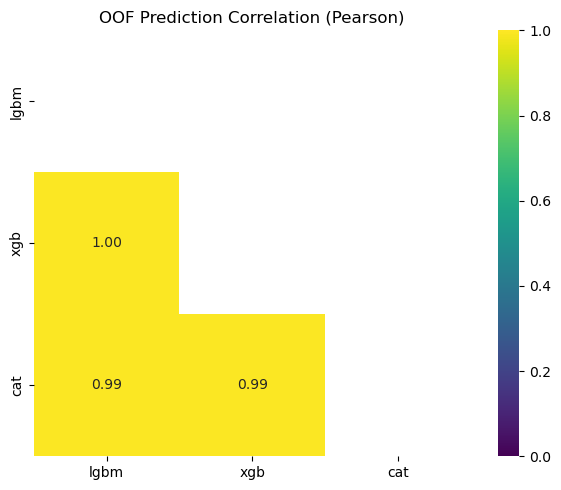

In [6]:
# C) Visual heatmap of Pearson correlations (upper triangle masked)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr = corr_pearson.loc[pred_cols, pred_cols]
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(6,5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", vmin=0, vmax=1, cmap="viridis", cbar=True)
plt.title("OOF Prediction Correlation (Pearson)")
plt.tight_layout()
plt.show()

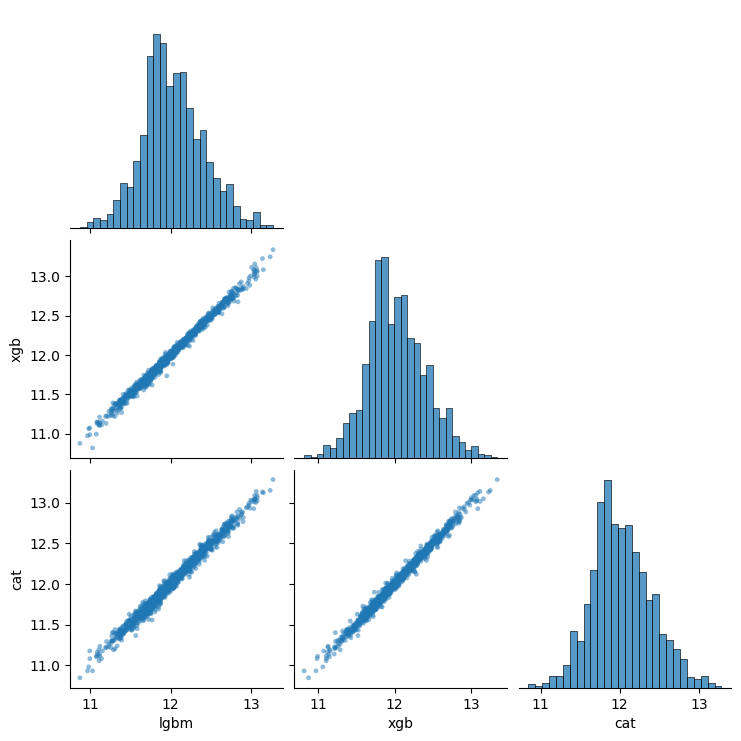

In [7]:
# D) Optional: pairwise scatter of model OOF predictions (quick visual redundancy check)
sns.pairplot(oof_aligned[pred_cols], corner=True, plot_kws=dict(alpha=0.5, s=12, edgecolor="none"))

In [8]:
# E) (Optional) Correlation on TEST submissions (log space), useful to judge blend diversity
SUB_DIR = ARTIFACTS_DIR / "submissions"
subs_candidates = {
    name: SUB_DIR / f"{name}_v02_baseline_nbhdstrat.csv" for name in names
}
# If you used optuna run-names, adjust the paths above accordingly.

subs_parts = []
subs_names = []
for name, path in subs_candidates.items():
    if path.exists():
        dfp = pd.read_csv(path).sort_values("Id")
        dfp["logp"] = np.log1p(dfp["SalePrice"])
        subs_parts.append(dfp[["Id","logp"]].rename(columns={"logp": f"logp_{name}"}))
        subs_names.append(name)

sub_aligned = subs_parts[0]
for dfp in subs_parts[1:]:
    sub_aligned = sub_aligned.merge(dfp, on="Id", how="inner")

test_corr = sub_aligned[[f"logp_{n}" for n in subs_names]].corr(method="pearson").round(3)
test_corr

,logp_lgbm,logp_xgb,logp_cat
logp_lgbm,1.000,0.995,0.995
logp_xgb,0.995,1.000,0.994
logp_cat,0.995,0.994,1.000


In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"
ARTIFACTS_DIR = Path("../artifacts")
OOF_DIR = ARTIFACTS_DIR / "oof"
SUB_DIR = ARTIFACTS_DIR / "submissions"
FIG_DIR = ARTIFACTS_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# pick the first Cat OOF that exists
cat_oof_candidates = [
    OOF_DIR / "cat_v02_baseline_nbhdstrat_oof.csv",
    OOF_DIR / "cat_v02_optuna_nbhdstrat_oof.csv",
    OOF_DIR / "cat_v02_seedavg3_nbhdstrat_oof.csv",
]
for p in cat_oof_candidates:
    if p.exists():
        CAT_OOF_PATH = p
        break

# likewise for submission (for later residual-correction on test)
cat_sub_candidates = [
    SUB_DIR / "cat_v02_baseline_nbhdstrat.csv",
    SUB_DIR / "cat_v02_optuna_nbhdstrat.csv",
    SUB_DIR / "cat_v02_seedavg3_nbhdstrat.csv",
]
for p in cat_sub_candidates:
    if p.exists():
        CAT_SUB_PATH = p
        break

# load train features + folds + target
df_tr = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv")
folds_df = pd.read_csv(PROCESSED_DIR / "cv_folds_strat_nbhd_price_v01.csv")
df_tr = df_tr.merge(folds_df, on="Id", how="left")

# load OOF preds (log)
oof = pd.read_csv(CAT_OOF_PATH).rename(columns={"pred_log":"pred_log_cat"})
df_res = df_tr.merge(oof, on="Id", how="inner")

# compute residuals (log-domain and original)
df_res["y_log"] = np.log1p(df_res["SalePrice"])
df_res["resid_log"] = df_res["y_log"] - df_res["pred_log_cat"]
df_res["pred_orig"] = np.expm1(df_res["pred_log_cat"])
df_res["resid_orig"] = df_res["SalePrice"] - df_res["pred_orig"]

df_res.shape

(1458, 139)

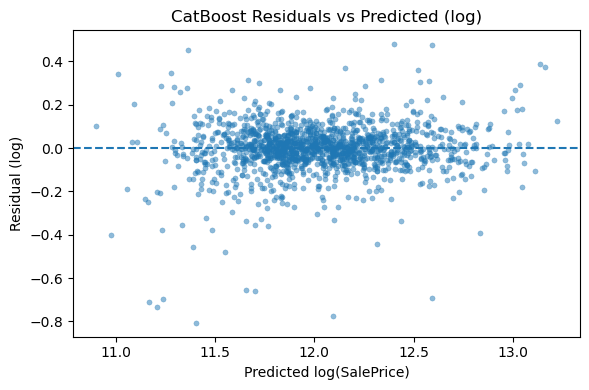

In [10]:
# Residual vs Predicted (log)
plt.figure(figsize=(6,4))
sns.scatterplot(x=df_res["pred_log_cat"], y=df_res["resid_log"], s=14, alpha=0.5, edgecolor=None)
plt.axhline(0, ls="--")
plt.xlabel("Predicted log(SalePrice)")
plt.ylabel("Residual (log)")
plt.title("CatBoost Residuals vs Predicted (log)")
plt.tight_layout()
plt.show()

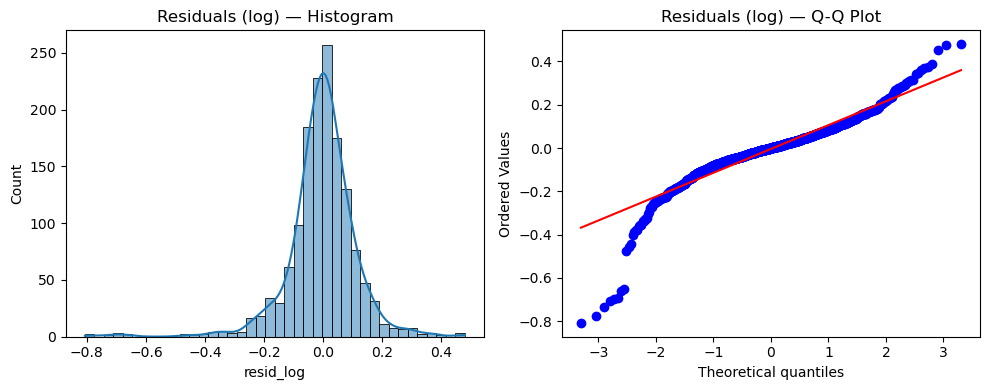

In [11]:
# Residual histogram (log) and QQ-plot
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.histplot(df_res["resid_log"], bins=40, kde=True, ax=ax[0])
ax[0].set_title("Residuals (log) — Histogram")
ax[0].set_xlabel("resid_log")

stats.probplot(df_res["resid_log"], dist="norm", plot=ax[1])
ax[1].set_title("Residuals (log) — Q-Q Plot")
plt.tight_layout()
plt.show()

In [12]:
# Price bins (by true log price) — where are errors concentrated?
df_res["price_bin_q"] = pd.qcut(df_res["y_log"], q=5, duplicates="drop")
grp_price = (df_res
             .groupby("price_bin_q")
             .agg(n=("Id","count"),
                  rmse_log=("resid_log", lambda s: float(np.sqrt(np.mean(s**2)))),
                  mean_resid_log=("resid_log","mean"),
                  rmse_orig=("resid_orig", lambda s: float(np.sqrt(np.mean(s**2)))),
                  mean_resid_orig=("resid_orig","mean"))
             .reset_index()
            ).sort_values("rmse_log", ascending=False)
grp_price

/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_48177/286556050.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_bin_q")


,price_bin_q,n,rmse_log,mean_resid_log,rmse_orig,mean_resid_orig
0,"(10.459000000000001, 11.728]",295,0.177539,-0.066421,16220.329101,-6323.485381
4,"(12.346, 13.534]",289,0.118117,0.034269,41790.532846,11324.004687
1,"(11.728, 11.898]",294,0.098093,-0.004071,15171.009988,-1247.214040
2,"(11.898, 12.096]",286,0.081060,0.011274,13018.351635,1309.354567
3,"(12.096, 12.346]",294,0.076666,0.006165,15337.577993,842.255902


In [13]:
# Neighborhood slice diagnostics (top-10 hardest by rmse_log)
grp_nbhd = (df_res
            .groupby("Neighborhood")
            .agg(n=("Id","count"),
                 rmse_log=("resid_log", lambda s: float(np.sqrt(np.mean(s**2)))),
                 mean_resid_log=("resid_log","mean"),
                 rmse_orig=("resid_orig", lambda s: float(np.sqrt(np.mean(s**2)))),
                 mean_resid_orig=("resid_orig","mean"))
            .reset_index()
           ).sort_values("rmse_log", ascending=False)
grp_nbhd.head(10)

,Neighborhood,n,rmse_log,mean_resid_log,rmse_orig,mean_resid_orig
8,IDOTRR,37,0.266106,-0.071862,18333.662873,-2876.786757
15,OldTown,113,0.155301,-0.023792,23581.808852,-287.551141
6,Edwards,98,0.149385,-0.009559,19427.612152,922.262084
21,StoneBr,25,0.138395,0.046758,47839.926291,19648.691005
2,BrkSide,58,0.135818,0.032526,16190.156609,6060.782806
3,ClearCr,28,0.127694,0.011258,27066.236686,4437.522652
5,Crawfor,51,0.123330,0.033599,30016.862622,10532.923875
18,Sawyer,74,0.121422,-0.007949,14258.706531,-233.447578
13,NoRidge,41,0.121195,0.013183,59355.401796,12046.889075
17,SWISU,25,0.116922,0.007802,16037.439643,2226.312265


In [14]:
# Decade & style slices (adjust if you already have engineered decade)
df_res["Decade"] = (df_res["YearBuilt"] // 10) * 10
grp_decade = (df_res.groupby("Decade")
              .agg(n=("Id","count"),
                   rmse_log=("resid_log", lambda s: float(np.sqrt(np.mean(s**2)))))
              .reset_index()
              .sort_values("rmse_log", ascending=False))
grp_style = (df_res.groupby("HouseStyle")
             .agg(n=("Id","count"),
                  rmse_log=("resid_log", lambda s: float(np.sqrt(np.mean(s**2)))))
             .reset_index()
             .sort_values("rmse_log", ascending=False))
grp_decade.head(10), grp_style.head(10)

(    Decade    n  rmse_log
 2     1890    6  0.248685
 14    2010    1  0.235547
 5     1920   97  0.175181
 7     1940   79  0.165879
 4     1910   58  0.159640
 3     1900   15  0.157893
 6     1930   54  0.140239
 0     1870    2  0.136283
 9     1960  175  0.108180
 8     1950  167  0.107079,
   HouseStyle    n  rmse_log
 5      Other    8  0.187646
 0     1.5Fin  154  0.144984
 2     1Story  726  0.122356
 3     2.5Unf   11  0.113462
 1     1.5Unf   14  0.101460
 4     2Story  443  0.098374
 7       SLvl   65  0.095367
 6     SFoyer   37  0.076205)

In [15]:
# Worst 20 absolute residuals — inspect for patterns
cols_show = ["Id","Neighborhood","OverallQual","GrLivArea","TotalBsmtSF","GarageCars",
             "YearBuilt","SaleCondition","SaleType","MSSubClass",
             "SalePrice","pred_orig","resid_orig","resid_log","fold"]
worst20 = df_res.reindex(df_res["resid_orig"].abs().sort_values(ascending=False).index).head(20)[cols_show]
worst20

,Id,Neighborhood,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,YearBuilt,SaleCondition,SaleType,MSSubClass,SalePrice,pred_orig,resid_orig,resid_log,fold
1181,1183,NoRidge,10,4476,2396.0,3,1996,Abnorml,WD,60,745000.0,505951.276044,239048.723956,0.386943,0
690,692,NoRidge,10,4316,2444.0,3,1994,Normal,WD,60,755000.0,519792.075297,235207.924703,0.373288,1
185,186,OldTown,10,3608,1107.0,3,1892,Normal,WD,75,475000.0,294655.989392,180344.010608,0.477505,4
897,899,NridgHt,9,2364,2330.0,3,2009,Partial,New,20,611657.0,458090.293901,153566.706099,0.289105,3
687,689,StoneBr,8,1419,1419.0,2,2007,Partial,New,20,392000.0,242701.789235,149298.210765,0.479427,1
1322,1325,Somerst,8,1795,1795.0,3,2006,Partial,New,20,147000.0,293662.545562,-146662.545562,-0.691995,2
802,804,NridgHt,9,2822,1734.0,3,2008,Partial,New,60,582933.0,445995.924432,136937.075568,0.267762,4
580,582,NridgHt,8,2042,2042.0,3,2008,Partial,New,20,253293.0,373947.376812,-120654.376812,-0.389567,3
1180,1182,Crawfor,8,1652,1600.0,2,2008,Partial,New,120,392500.0,273842.828073,118657.171927,0.359981,2
440,441,NridgHt,10,2402,3094.0,3,2008,Normal,WD,20,555000.0,440813.697221,114186.302779,0.230345,3


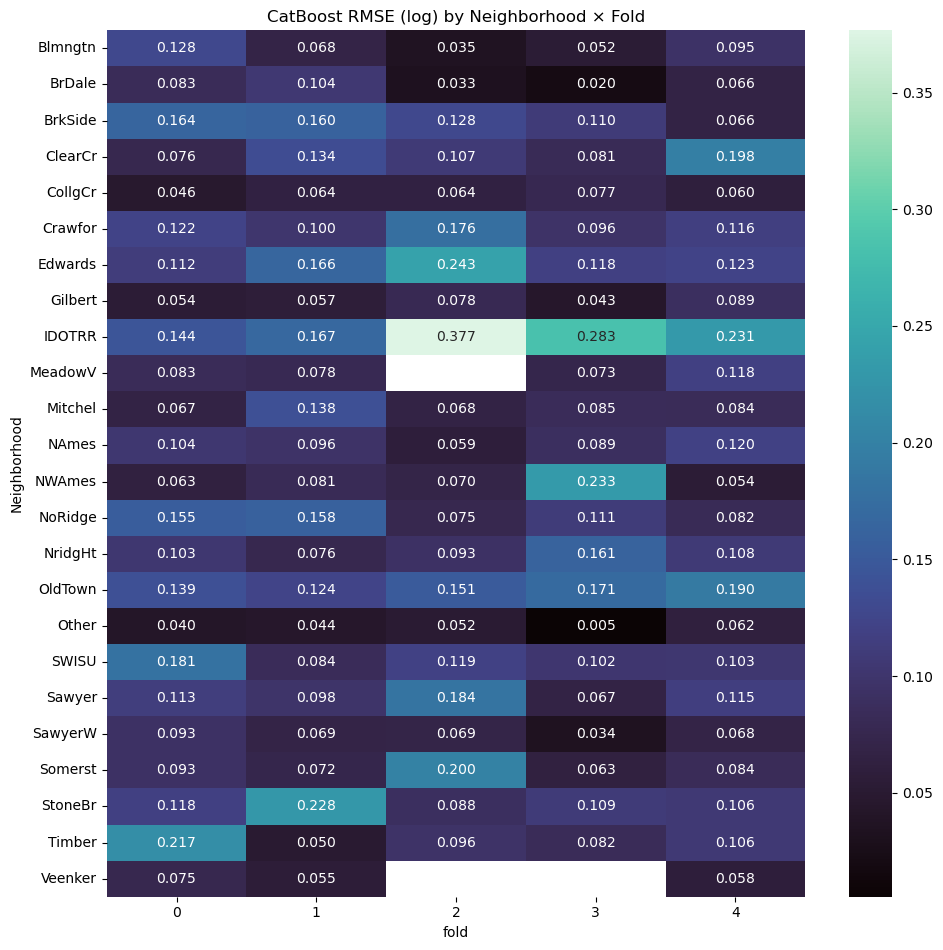

In [16]:
pivot_nbhd_fold = (df_res
    .groupby(["Neighborhood","fold"])
    .agg(rmse_log=("resid_log", lambda s: float(np.sqrt(np.mean(s**2)))))
    .reset_index()
    .pivot(index="Neighborhood", columns="fold", values="rmse_log"))

plt.figure(figsize=(10, max(4, 0.4*len(pivot_nbhd_fold))))
sns.heatmap(pivot_nbhd_fold, annot=True, fmt=".3f", cmap="mako", cbar=True)
plt.title("CatBoost RMSE (log) by Neighborhood × Fold")
plt.tight_layout()
plt.show()

In [18]:
# === Isotonic calibration on Cat OOF ===
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error

DATA_DIR = Path("../data"); PROCESSED_DIR = DATA_DIR / "processed"
ART = Path("../artifacts"); OOF_DIR = ART / "oof"; SUB_DIR = ART / "submissions"
ART.mkdir(parents=True, exist_ok=True)

# Load training truth + folds
df_tr = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv", usecols=["Id","SalePrice"])
df_tr["y_log"] = np.log1p(df_tr["SalePrice"])

# Pick Cat OOF + submission (adjust names if you used different tag)
oof_path = OOF_DIR / "cat_v02_optuna_nbhdstrat_oof.csv"
sub_path = SUB_DIR / "cat_v02_optuna_nbhdstrat.csv"

oof = pd.read_csv(oof_path).rename(columns={"pred_log":"pred_log_cat"})
oof = oof.merge(df_tr[["Id","y_log"]], on="Id", how="left")

# Fit isotonic on OOF (no leakage; OOF acts like held-out points)
iso = IsotonicRegression(out_of_bounds="clip")
_ = iso.fit(oof["pred_log_cat"].values, oof["y_log"].values)

# Calibrated OOF + metric
oof["pred_log_cal"] = iso.transform(oof["pred_log_cat"].values)
rmse_base = float(np.sqrt(mean_squared_error(oof["y_log"], oof["pred_log_cat"])))
rmse_cal  = float(np.sqrt(mean_squared_error(oof["y_log"], oof["pred_log_cal"])))
pd.DataFrame({"metric":["cv_rmse_log_base_cat","cv_rmse_log_cat_calibrated"],
              "value":[rmse_base, rmse_cal]})

# Apply to TEST submission
sub = pd.read_csv(sub_path).sort_values("Id")
logp_test = np.log1p(sub["SalePrice"].values)
logp_test_cal = iso.transform(logp_test)
sub_cal = pd.DataFrame({"Id": sub["Id"].values, "SalePrice": np.expm1(logp_test_cal)})

tag = "cat_v02_optuna_nbhdstrat_iso"
oof_out = OOF_DIR / f"{tag}_oof.csv"
sub_out = SUB_DIR / f"{tag}.csv"
oof[["Id","pred_log_cal"]].rename(columns={"pred_log_cal":"pred_log"}).to_csv(oof_out, index=False)
sub_cal.to_csv(sub_out, index=False)

pd.Series({"oof_path": str(oof_out), "submission_path": str(sub_out)})

oof_path           ../artifacts/oof/cat_v02_optuna_nbhdstrat_iso_...
submission_path    ../artifacts/submissions/cat_v02_optuna_nbhdst...
dtype: object

In [21]:
# === Residual corrector: XGB (depth=2) on resid_log ===
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Base Cat OOF residuals (reuse your existing df_res if you already have it)
folds_df = pd.read_csv(PROCESSED_DIR / "cv_folds_strat_nbhd_price_v01.csv")
df_feat = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv")
oof = pd.read_csv(OOF_DIR / "cat_v02_optuna_nbhdstrat_oof.csv").rename(columns={"pred_log":"pred_log_cat"})
df = (df_feat.merge(folds_df, on="Id", how="left")
             .merge(df_tr[["Id","y_log"]], on="Id", how="left")
             .merge(oof, on="Id", how="left"))
df["resid_log"] = df["y_log"] - df["pred_log_cat"]

# Features dedicated to residual patterns (tiny set; includes key cats)
resid_feats = [
    "OverallQual","OverallCond","GrLivArea","TotalBsmtSF","GarageCars","YearBuilt",
    "LotArea","1stFlrSF","2ndFlrSF","GarageArea",
    "Neighborhood","SaleCondition","SaleType","MSSubClass"
]
resid_feats = [c for c in resid_feats if c in df.columns]
Xr = df[resid_feats].copy()
for c in ["Neighborhood","SaleCondition","SaleType","MSSubClass"]:
    if c in Xr.columns:
        Xr[c] = Xr[c].astype("category")

y_res = df["resid_log"].values
fold = df["fold"].values

# Fold-wise fit → OOF corrections
oof_corr = np.zeros(len(df))
models = []
for k in sorted(np.unique(fold)):
    tr_idx = np.where(fold != k)[0]
    va_idx = np.where(fold == k)[0]

    model = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        enable_categorical=True,
        max_depth=2,
        n_estimators=1500,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        early_stopping_rounds=100,
        random_state=42
    )
    _ = model.fit(
        Xr.iloc[tr_idx], y_res[tr_idx],
        eval_set=[(Xr.iloc[va_idx], y_res[va_idx])],

        verbose=False
    )
    oof_corr[va_idx] = model.predict(Xr.iloc[va_idx])
    models.append(model)

# Evaluate adjusted OOF & save adjusted OOF/SUB
pred_log_base = df["pred_log_cat"].values
pred_log_adj  = pred_log_base + oof_corr
rmse_adj = float(np.sqrt(mean_squared_error(df["y_log"].values, pred_log_adj)))
pd.DataFrame({
    "metric": ["cv_rmse_log_base_cat", "cv_rmse_log_cat_plus_xgbresid"],
    "value":  [rmse_base, rmse_adj]
})

# Apply residual corrector to TEST (average across fold models)
df_te = pd.read_csv(PROCESSED_DIR / "hp_test_feat_v02.csv")
Xt = df_te[resid_feats].copy()
for c in ["Neighborhood","SaleCondition","SaleType","MSSubClass"]:
    if c in Xt.columns:
        Xt[c] = Xt[c].astype("category")

sub = pd.read_csv(SUB_DIR / "cat_v02_optuna_nbhdstrat.csv").sort_values("Id")
logp_test = np.log1p(sub["SalePrice"].values)

corr_test = np.column_stack([m.predict(Xt) for m in models]).mean(axis=1)
logp_test_adj = logp_test + corr_test
sub_adj = pd.DataFrame({"Id": sub["Id"].values, "SalePrice": np.expm1(logp_test_adj)})

tag = "cat_plus_xgbresid_v02_nbhdstrat"
pd.DataFrame({"Id": df["Id"], "pred_log": pred_log_adj}).to_csv(OOF_DIR / f"{tag}_oof.csv", index=False)
sub_adj.to_csv(SUB_DIR / f"{tag}.csv", index=False)

In [22]:
# === feature hooks for v3 (train-only quantiles) ===
import numpy as np, pandas as pd
df_tr = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv")
df_te = pd.read_csv(PROCESSED_DIR / "hp_test_feat_v02.csv")

def add_segments(df, q):
    df["Seg_IDOTRR"]  = (df["Neighborhood"]=="IDOTRR").astype(int)
    df["Seg_OldTown"] = (df["Neighborhood"]=="OldTown").astype(int)
    df["Seg_StoneBr"] = (df["Neighborhood"]=="StoneBr").astype(int)
    df["Seg_Partial"] = (df["SaleCondition"]=="Partial").astype(int)
    df["Seg_Family"]  = (df["SaleCondition"]=="Family").astype(int)
    df["Seg_Alloca"]  = (df["SaleCondition"]=="Alloca").astype(int)
    # proxies for tails (train quantiles only)
    df["Seg_LuxuryProxy"] = ((df["OverallQual"] >= q["qual90"]) | 
                             (df["GrLivArea"] >= q["grliv90"]) |
                             (df.get("TotalSF", df["GrLivArea"]) >= q["totalsf90"])).astype(int)
    df["Seg_BudgetProxy"] = ((df["OverallQual"] <= q["qual40"]) & 
                              (df["GrLivArea"] <= q["grliv40"])).astype(int)
    return df

q = {
    "qual90":  df_tr["OverallQual"].quantile(0.90),
    "qual40":  df_tr["OverallQual"].quantile(0.40),
    "grliv90": df_tr["GrLivArea"].quantile(0.90),
    "grliv40": df_tr["GrLivArea"].quantile(0.40),
    "totalsf90": (df_tr["GrLivArea"] + df_tr.get("TotalBsmtSF", pd.Series(0))).quantile(0.90)
}

df_tr_v3 = add_segments(df_tr.copy(), q)
df_te_v3 = add_segments(df_te.copy(), q)

# Save v3 for training (keep your existing metadata update process)
df_tr_v3.to_csv(PROCESSED_DIR / "hp_train_feat_v03.csv", index=False)
df_te_v3.to_csv(PROCESSED_DIR / "hp_test_feat_v03.csv", index=False)

In [23]:
# Cell 1 — imports & paths
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor, Pool

DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"
ARTIFACTS_DIR = Path("../artifacts")
OOF_DIR = ARTIFACTS_DIR / "oof"
SUB_DIR = ARTIFACTS_DIR / "submissions"
CFG_DIR = ARTIFACTS_DIR / "configs"
FIG_DIR = ARTIFACTS_DIR / "figures"

for d in [ARTIFACTS_DIR, OOF_DIR, SUB_DIR, CFG_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# choose the config produced by your previous Optuna run
# adjust name if your run tag differs
CONFIG_PATH = CFG_DIR / "cat_v02_optuna_nbhdstrat_best_params.yaml"

RUN_TAG = "cat_v02_refit_prevbest_nbhdstrat"
TOPK = 30

In [24]:
# Cell 2 — load best params (parses the simple "key: value" format)
def parse_scalar(v):
    s = str(v).strip()
    if s.lower() in {"true","false"}:
        return s.lower() == "true"
    try:
        if "." in s or "e" in s.lower():
            return float(s)
        return int(s)
    except ValueError:
        return s

best_params_txt = CONFIG_PATH.read_text()
best_params = {}
for line in best_params_txt.splitlines():
    if not line.strip() or line.strip().startswith("#") or ":" not in line:
        continue
    k, v = line.split(":", 1)
    best_params[k.strip()] = parse_scalar(v)

# make sure required keys exist / are fixed
best_params.setdefault("loss_function", "RMSE")
best_params.setdefault("eval_metric", "RMSE")
best_params.setdefault("od_type", "Iter")
best_params.setdefault("od_wait", 200)
best_params.setdefault("allow_writing_files", False)
best_params.setdefault("verbose", False)
best_params.setdefault("random_seed", 42)

best_params

{'allow_writing_files': False,
 'bagging_temperature': 3.445536647852161,
 'depth': 5,
 'eval_metric': 'RMSE',
 'iterations': 20000,
 'l2_leaf_reg': 1.2124687203860003,
 'learning_rate': 0.03073956868595983,
 'loss_function': 'RMSE',
 'od_type': 'Iter',
 'od_wait': 200,
 'random_strength': 1.7551455174422934,
 'rsm': 0.6498995775663868,
 'subsample': 0.8460004149791289,
 'verbose': False,
 'random_seed': 42}

In [25]:
# Cell 3 — load data, folds, target; prep categoricals as strings (no NaN)
with open(PROCESSED_DIR / "hp_clean_meta_v03.json", "r") as f:
    meta = __import__("json").load(f)

df_tr = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv")
df_te = pd.read_csv(PROCESSED_DIR / "hp_test_feat_v02.csv")
folds = pd.read_csv(PROCESSED_DIR / "cv_folds_strat_nbhd_price_v01.csv")

df_tr = df_tr.merge(folds, on="Id", how="left")
df_tr["y_log"] = np.log1p(df_tr["SalePrice"])

id_col, target_col = "Id", "SalePrice"
feature_cols = [c for c in df_tr.columns if c not in [id_col, target_col, "fold", "y_log"]]

# categorical names (from meta + any engineered cats present)
nominal_cols = set(meta.get("nominal_cols_final", [])) | set(meta.get("engineered_nominal", []))
maybe_engineered = {"Nbhd_Qual_cat_v2", "Nbhd_Decade_cat_v2", "NbhdCluster4_v2"}
nominal_cols |= {c for c in maybe_engineered if c in df_tr.columns}
cat_cols = [c for c in feature_cols if c in nominal_cols]

def to_cat_strings(df, cols, token="Missing"):
    for c in cols:
        df[c] = df[c].astype("object").where(df[c].notna(), token).astype(str)
    return df

X = df_tr[feature_cols].copy()
T = df_te[feature_cols].copy()
X = to_cat_strings(X, cat_cols)
T = to_cat_strings(T, cat_cols)

cat_idx = [X.columns.get_loc(c) for c in cat_cols]
fold = df_tr["fold"].values
y_log = df_tr["y_log"].values

len(feature_cols), len(cat_cols), sorted(np.unique(fold))

(131, 36, [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)])

In [26]:
# Cell 4 — CV refit using best params → OOF (log), per-fold test preds, fold RMSEs
oof = np.zeros(len(X), dtype=float)
test_folds = []
fold_scores = []

for k in sorted(np.unique(fold)):
    tr_idx = np.where(fold != k)[0]
    va_idx = np.where(fold == k)[0]

    train_pool = Pool(X.iloc[tr_idx], label=y_log[tr_idx], cat_features=cat_idx)
    valid_pool = Pool(X.iloc[va_idx], label=y_log[va_idx], cat_features=cat_idx)
    test_pool  = Pool(T, cat_features=cat_idx)

    model = CatBoostRegressor(**best_params)
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    pred_va = model.predict(valid_pool)
    oof[va_idx] = pred_va
    fold_scores.append(float(np.sqrt(mean_squared_error(y_log[va_idx], pred_va))))

    test_folds.append(model.predict(test_pool))

cv_rmse_mean_log = float(np.mean(fold_scores))
cv_rmse_std_log  = float(np.std(fold_scores))

pd.DataFrame({
    "metric": ["cv_rmse_mean_log","cv_rmse_std_log"] + [f"fold{i}_rmse_log" for i in range(len(fold_scores))],
    "value":  [cv_rmse_mean_log,  cv_rmse_std_log]  + fold_scores
})

,metric,value
0,cv_rmse_mean_log,0.111415
1,cv_rmse_std_log,0.008052
2,fold0_rmse_log,0.104133
3,fold1_rmse_log,0.106634
4,fold2_rmse_log,0.125317
5,fold3_rmse_log,0.115658
6,fold4_rmse_log,0.105332


In [27]:
# Cell 5 — save OOF & submission, compute feature importance, and save plots
oof_df = pd.DataFrame({"Id": df_tr["Id"].values, "pred_log": oof})
sub_pred_log = np.column_stack(test_folds).mean(axis=1)
sub_df = pd.DataFrame({"Id": df_te["Id"].values, "SalePrice": np.expm1(sub_pred_log)})

oof_path = OOF_DIR / f"{RUN_TAG}_oof.csv"
sub_path = SUB_DIR / f"{RUN_TAG}.csv"
oof_df.to_csv(oof_path, index=False)
sub_df.to_csv(sub_path, index=False)

# Fit a final model on full data (optional, for importance)
full_pool = Pool(X, label=y_log, cat_features=cat_idx)
final_model = CatBoostRegressor(**best_params)
final_model.fit(full_pool)

fi_vals = final_model.get_feature_importance(full_pool, type="PredictionValuesChange")
fi_df = pd.DataFrame({"feature": X.columns, "importance": fi_vals}).sort_values("importance", ascending=False)

# plots: top-K and all
top = fi_df.head(TOPK).sort_values("importance", ascending=True)
plt.figure(figsize=(9, 10))
plt.barh(top["feature"], top["importance"])
plt.xlabel("CatBoost Importance (PredictionValuesChange)")
plt.ylabel("Feature")
plt.title(f"CatBoost Feature Importance — Top {TOPK}")
plt.tight_layout()
top_png = FIG_DIR / f"{RUN_TAG}_feat_importance_top{TOPK}.png"
plt.savefig(top_png, dpi=200, bbox_inches="tight"); plt.close()

height_in = float(np.clip(len(fi_df) * 0.25, 6.0, 60.0))
plt.figure(figsize=(10, height_in))
plt.barh(fi_df.sort_values("importance")["feature"], fi_df.sort_values("importance")["importance"])
plt.xlabel("CatBoost Importance (PredictionValuesChange)")
plt.ylabel("Feature")
plt.title(f"CatBoost Feature Importance — All {len(fi_df)}")
plt.tight_layout()
all_png = FIG_DIR / f"{RUN_TAG}_feat_importance_all.png"
plt.savefig(all_png, dpi=200, bbox_inches="tight"); plt.close()

pd.Series({
    "oof_csv": str(oof_path),
    "submission_csv": str(sub_path),
    "feat_importance_csv": str(FIG_DIR / f"{RUN_TAG}_feat_importance.csv"),
    "feat_importance_top_png": str(top_png),
    "feat_importance_all_png": str(all_png),
})

oof_csv                    ../artifacts/oof/cat_v02_refit_prevbest_nbhdst...
submission_csv             ../artifacts/submissions/cat_v02_refit_prevbes...
feat_importance_csv        ../artifacts/figures/cat_v02_refit_prevbest_nb...
feat_importance_top_png    ../artifacts/figures/cat_v02_refit_prevbest_nb...
feat_importance_all_png    ../artifacts/figures/cat_v02_refit_prevbest_nb...
dtype: object

In [29]:
# Cell 6 — (optional) save importance as CSV for MLflow/records
fi_csv = FIG_DIR / f"{RUN_TAG}_feat_importance.csv"
fi_df.to_csv(fi_csv, index=False)
fi_df.head(50)

,feature,importance
118,Qual_x_NbhdPrem_v2,9.314200
119,LogTotalSF_x_NbhdPrem_v2,8.302110
112,int_OQual_x_TotalSF,7.345964
111,int_OQual_x_GrLiv,4.828432
81,fe_TotalSF,4.540103
117,TotalSF_log1p_v2,3.825575
115,TotalSF,3.601961
16,OverallQual,3.392934
98,fe_OverallGrade,2.810913
83,fe_TotalBaths,2.414409


In [30]:
# Cell 1 — paths & load v3 train + folds + Cat OOF (v3)
from pathlib import Path
import numpy as np
import pandas as pd

DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"
ARTIFACTS_DIR = Path("../artifacts")
OOF_DIR = ARTIFACTS_DIR / "oof"
SUB_DIR = ARTIFACTS_DIR / "submissions"
FIG_DIR = ARTIFACTS_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# v3 features
df_tr = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v03.csv")
folds = pd.read_csv(PROCESSED_DIR / "cv_folds_strat_nbhd_price_v01.csv")
df_tr = df_tr.merge(folds, on="Id", how="left")
df_tr["y_log"] = np.log1p(df_tr["SalePrice"])

# choose a CatBoost OOF for v3 (adjust if your filename differs)
cat_oof_candidates = [
    OOF_DIR / "cat_v02_refit_prevbest_nbhdstrat_oof.csv",
]
for p in cat_oof_candidates:
    if p.exists():
        CAT_OOF_PATH = p
        break

oof = pd.read_csv(CAT_OOF_PATH).rename(columns={"pred_log": "pred_log_cat"})
df_res = df_tr.merge(oof, on="Id", how="inner")

# residuals (log + original)
df_res["pred_orig"] = np.expm1(df_res["pred_log_cat"])
df_res["resid_log"]  = df_res["y_log"] - df_res["pred_log_cat"]
df_res["resid_orig"] = df_res["SalePrice"] - df_res["pred_orig"]

df_res.shape

(1458, 147)

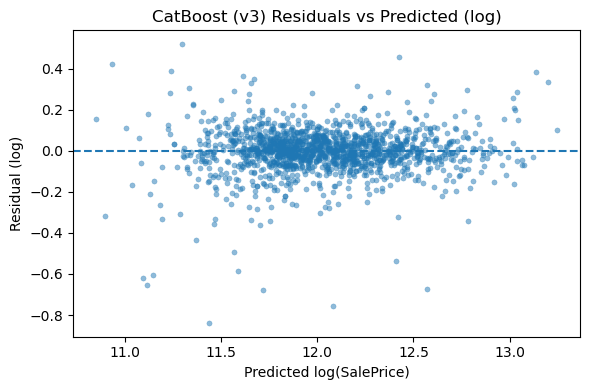

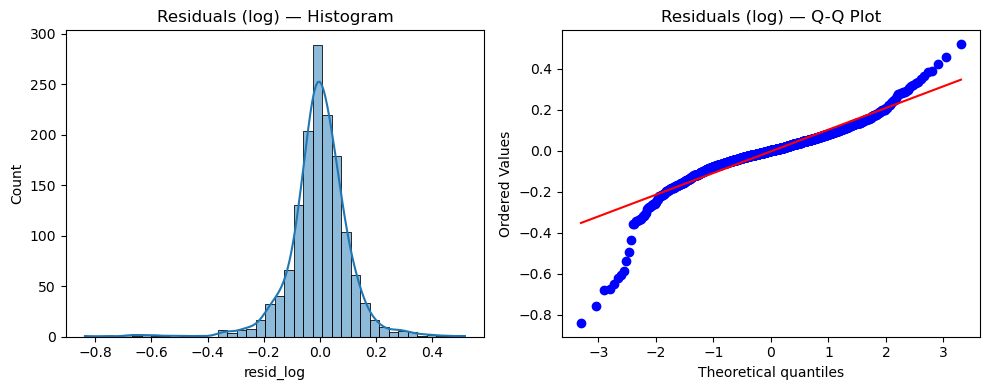

In [31]:
# Cell 2 — residual vs predicted (log), histogram, QQ
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.figure(figsize=(6,4))
sns.scatterplot(x=df_res["pred_log_cat"], y=df_res["resid_log"], s=14, alpha=0.5, edgecolor=None)
plt.axhline(0, ls="--")
plt.xlabel("Predicted log(SalePrice)")
plt.ylabel("Residual (log)")
plt.title("CatBoost (v3) Residuals vs Predicted (log)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.histplot(df_res["resid_log"], bins=40, kde=True, ax=ax[0])
ax[0].set_title("Residuals (log) — Histogram")
ax[0].set_xlabel("resid_log")
stats.probplot(df_res["resid_log"], dist="norm", plot=ax[1])
ax[1].set_title("Residuals (log) — Q-Q Plot")
plt.tight_layout()
plt.show()

In [32]:
# Cell 3 — price-bin diagnostics (true y_log quantiles)
df_res["price_bin_q"] = pd.qcut(df_res["y_log"], q=5, duplicates="drop")
grp_price = (df_res
             .groupby("price_bin_q")
             .agg(n=("Id","count"),
                  rmse_log=("resid_log", lambda s: float(np.sqrt(np.mean(s**2)))),
                  mean_resid_log=("resid_log","mean"),
                  rmse_orig=("resid_orig", lambda s: float(np.sqrt(np.mean(s**2)))),
                  mean_resid_orig=("resid_orig","mean"))
             .reset_index()
             .sort_values("rmse_log", ascending=False))
grp_price

/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_48177/3074622087.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_bin_q")


,price_bin_q,n,rmse_log,mean_resid_log,rmse_orig,mean_resid_orig
0,"(10.459000000000001, 11.728]",295,0.168337,-0.058428,15383.680781,-5566.377386
4,"(12.346, 13.534]",289,0.107135,0.027135,38535.255315,9250.360438
1,"(11.728, 11.898]",294,0.098993,0.000156,15272.751432,-686.888918
2,"(11.898, 12.096]",286,0.082713,0.012223,13097.161907,1442.767729
3,"(12.096, 12.346]",294,0.075575,0.004091,15115.512388,410.278170


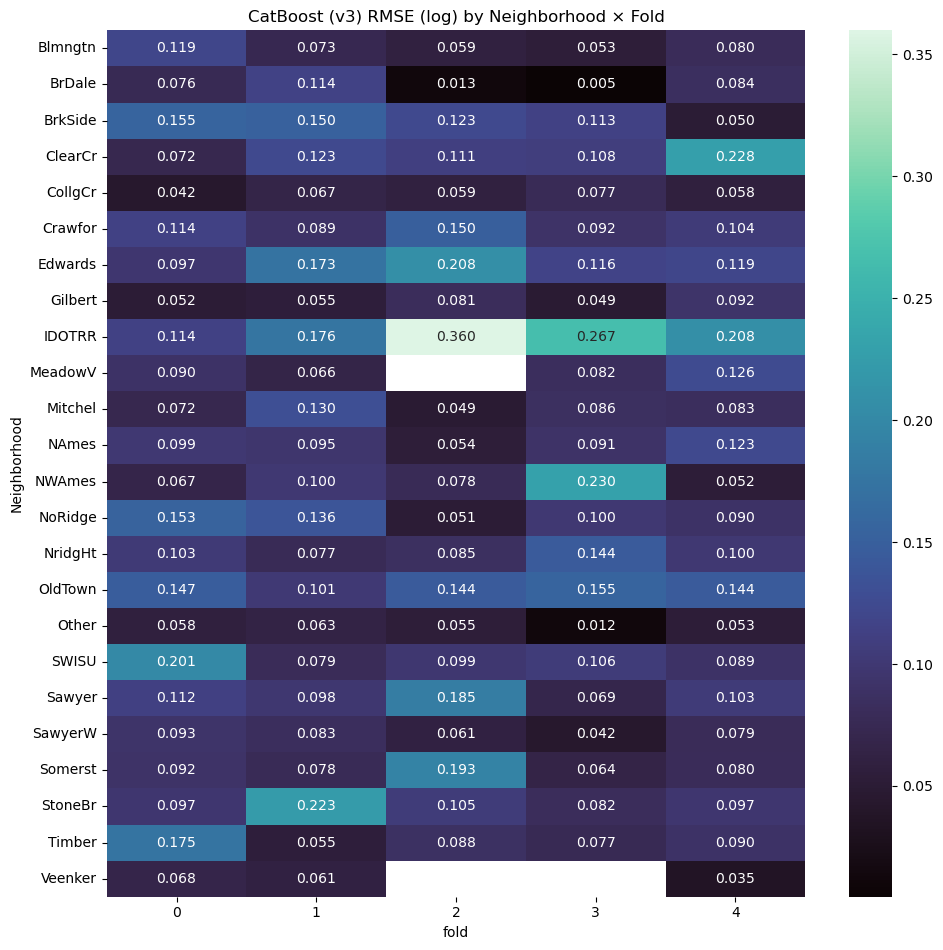

In [33]:
# Cell 4 — Neighborhood × fold heatmap of RMSE (log)
pivot_nbhd_fold = (df_res
    .groupby(["Neighborhood","fold"])
    .agg(rmse_log=("resid_log", lambda s: float(np.sqrt(np.mean(s**2)))))
    .reset_index()
    .pivot(index="Neighborhood", columns="fold", values="rmse_log"))

plt.figure(figsize=(10, max(4, 0.4*len(pivot_nbhd_fold))))
sns.heatmap(pivot_nbhd_fold, annot=True, fmt=".3f", cmap="mako", cbar=True)
plt.title("CatBoost (v3) RMSE (log) by Neighborhood × Fold")
plt.tight_layout()
plt.show()

In [34]:
# Cell 5 — segments you added in v3 (if present): counts + RMSE
seg_cols = [c for c in [
    "Seg_IDOTRR","Seg_OldTown","Seg_StoneBr",
    "Seg_Partial","Seg_Family","Seg_Alloca",
    "Seg_LuxuryProxy","Seg_BudgetProxy"
] if c in df_res.columns]

seg_summary = []
for c in seg_cols:
    g = (df_res.groupby(c)
         .agg(n=("Id","count"),
              rmse_log=("resid_log", lambda s: float(np.sqrt(np.mean(s**2)))),
              mean_resid_log=("resid_log","mean"),
              rmse_orig=("resid_orig", lambda s: float(np.sqrt(np.mean(s**2)))),
              mean_resid_orig=("resid_orig","mean"))
         .reset_index())
    g.insert(0, "segment", c)
    seg_summary.append(g)
seg_summary = pd.concat(seg_summary, ignore_index=True) if seg_summary else pd.DataFrame()
seg_summary

,segment,Seg_IDOTRR,n,rmse_log,mean_resid_log,rmse_orig,mean_resid_orig,Seg_OldTown,Seg_StoneBr,Seg_Partial,Seg_Family,Seg_Alloca,Seg_LuxuryProxy,Seg_BudgetProxy
0,Seg_IDOTRR,0.0,1421,0.105546,-0.001600,21762.901805,1022.511055,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Seg_IDOTRR,1.0,37,0.252743,-0.064232,17052.439332,-2443.442182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Seg_OldTown,NaN,1345,0.109002,-0.002146,21876.897303,1004.975091,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Seg_OldTown,NaN,113,0.139942,-0.015603,18829.336054,96.365942,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Seg_StoneBr,NaN,1433,0.111334,-0.003768,20972.298630,697.984595,NaN,0.0,NaN,NaN,NaN,NaN,NaN
5,Seg_StoneBr,NaN,25,0.131325,0.030014,46256.571517,14494.756942,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,Seg_Partial,NaN,1335,0.109383,-0.003526,19039.588963,722.823846,NaN,NaN,0.0,NaN,NaN,NaN,NaN
7,Seg_Partial,NaN,123,0.134366,0.000466,40307.071819,3232.609865,NaN,NaN,1.0,NaN,NaN,NaN,NaN
8,Seg_Family,NaN,1438,0.109695,-0.003076,21541.322745,969.837565,NaN,NaN,NaN,0.0,NaN,NaN,NaN
9,Seg_Family,NaN,20,0.210956,-0.011327,28727.616551,-1602.278503,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [35]:
# Cell 6 — worst absolute residuals (top 25) for manual spot-check
cols_show = ["Id","Neighborhood","OverallQual","GrLivArea","TotalBsmtSF","GarageCars",
             "YearBuilt","SaleCondition","SaleType","MSSubClass",
             "SalePrice","pred_orig","resid_orig","resid_log","fold"]
worst25 = df_res.reindex(df_res["resid_orig"].abs().sort_values(ascending=False).index).head(25)[cols_show]
worst25

,Id,Neighborhood,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,YearBuilt,SaleCondition,SaleType,MSSubClass,SalePrice,pred_orig,resid_orig,resid_log,fold
1181,1183,NoRidge,10,4476,2396.0,3,1996,Abnorml,WD,60,745000.0,506774.787762,238225.212238,0.385317,0
690,692,NoRidge,10,4316,2444.0,3,1994,Normal,WD,60,755000.0,540587.351515,214412.648485,0.334061,1
897,899,NridgHt,9,2364,2330.0,3,2009,Partial,New,20,611657.0,458748.165406,152908.834594,0.287670,3
687,689,StoneBr,8,1419,1419.0,2,2007,Partial,New,20,392000.0,248280.883762,143719.116238,0.456700,1
1322,1325,Somerst,8,1795,1795.0,3,2006,Partial,New,20,147000.0,288502.833906,-141502.833906,-0.674269,2
802,804,NridgHt,9,2822,1734.0,3,2008,Partial,New,60,582933.0,450097.226813,132835.773187,0.258608,4
185,186,OldTown,10,3608,1107.0,3,1892,Normal,WD,75,475000.0,353703.647185,121296.352815,0.294855,4
773,775,NridgHt,8,1973,1935.0,3,2006,Partial,New,20,395000.0,287518.892283,107481.107717,0.317596,0
1045,1047,StoneBr,9,2868,1992.0,3,2005,Partial,New,60,556581.0,451976.256656,104604.743344,0.208183,2
580,582,NridgHt,8,2042,2042.0,3,2008,Partial,New,20,253293.0,357153.959307,-103860.959307,-0.343619,3


In [36]:
# Cell 7 — summarize by Neighborhood (top-10 hardest by rmse_log)
grp_nbhd = (df_res
            .groupby("Neighborhood")
            .agg(n=("Id","count"),
                 rmse_log=("resid_log", lambda s: float(np.sqrt(np.mean(s**2)))),
                 mean_resid_log=("resid_log","mean"),
                 rmse_orig=("resid_orig", lambda s: float(np.sqrt(np.mean(s**2)))),
                 mean_resid_orig=("resid_orig","mean"))
            .reset_index()
            .sort_values("rmse_log", ascending=False))
grp_nbhd.head(10)

,Neighborhood,n,rmse_log,mean_resid_log,rmse_orig,mean_resid_orig
8,IDOTRR,37,0.252743,-0.064232,17052.439332,-2443.442182
6,Edwards,98,0.141166,-0.006129,17693.583843,824.673684
15,OldTown,113,0.139942,-0.015603,18829.336054,96.365942
3,ClearCr,28,0.137860,-0.013911,28935.321952,-1416.120796
21,StoneBr,25,0.131325,0.030014,46256.571517,14494.756942
2,BrkSide,58,0.128520,0.024017,15456.243267,4721.297228
18,Sawyer,74,0.119672,-0.005023,13845.332526,93.267966
17,SWISU,25,0.117535,0.013371,16213.422051,2851.535977
12,NWAmes,73,0.115051,-0.018846,18978.347333,-3447.202497
13,NoRidge,41,0.113025,0.010217,56222.165297,10516.655786


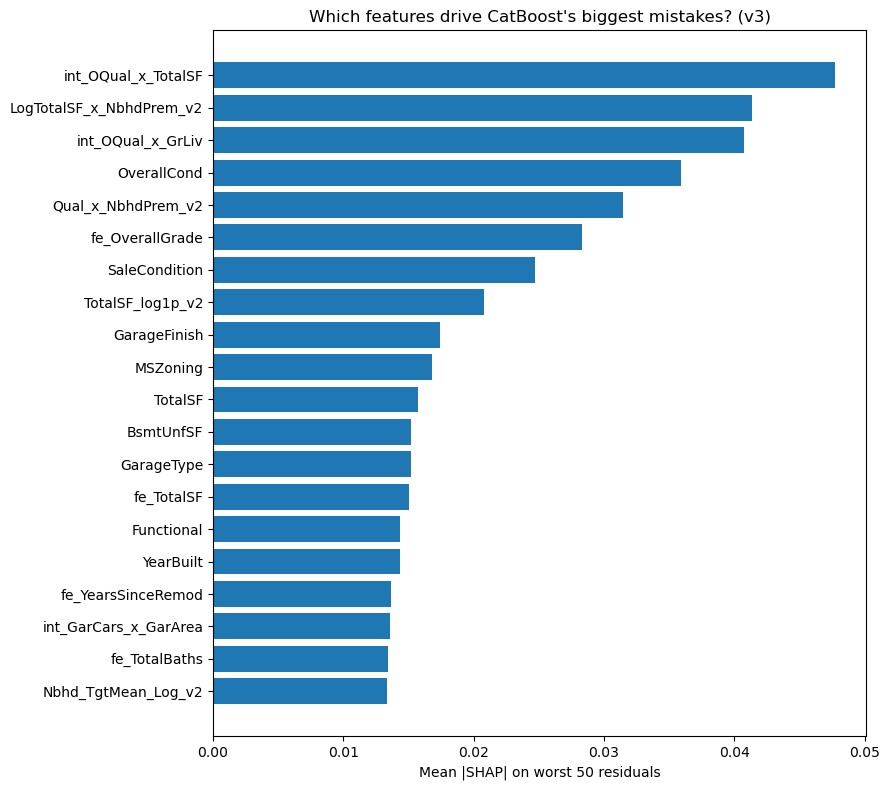

,feature,mean_abs_shap_worstK
112,int_OQual_x_TotalSF,0.047727
119,LogTotalSF_x_NbhdPrem_v2,0.041353
111,int_OQual_x_GrLiv,0.040759
17,OverallCond,0.035892
118,Qual_x_NbhdPrem_v2,0.031421
98,fe_OverallGrade,0.028323
78,SaleCondition,0.024673
117,TotalSF_log1p_v2,0.020757
59,GarageFinish,0.017400
1,MSZoning,0.016764


In [37]:
# Cell 8 — (optional) SHAP-on-worst: which features drive the biggest misses?
# Fits final CatBoost on full v3 with best params, then computes SHAP for worst 50 rows.
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

# load best params for v3 (fallback to v2 if needed)
CFG_DIR = ARTIFACTS_DIR / "configs"
cfg_candidates = [
    CFG_DIR / "cat_v03_optuna_nbhdstrat_best_params.yaml",
    CFG_DIR / "cat_v03_refit_prevbest_nbhdstrat_best_params.yaml",
    CFG_DIR / "cat_v02_optuna_nbhdstrat_best_params.yaml",
]
for p in cfg_candidates:
    if p.exists():
        CFG_PATH = p
        break

def parse_scalar(v):
    s = str(v).strip()
    if s.lower() in {"true","false"}:
        return s.lower() == "true"
    try:
        if "." in s or "e" in s.lower():
            return float(s)
        return int(s)
    except ValueError:
        return s

best_params = {}
for line in CFG_PATH.read_text().splitlines():
    if not line.strip() or line.strip().startswith("#") or ":" not in line:
        continue
    k, v = line.split(":", 1)
    best_params[k.strip()] = parse_scalar(v)

# build X / cat indices for v3
with open(PROCESSED_DIR / "hp_clean_meta_v03.json","r") as f:
    meta = __import__("json").load(f)

feature_cols = [c for c in df_tr.columns if c not in ["Id","SalePrice","fold","y_log","price_bin_q"]]
nominal_cols = set(meta.get("nominal_cols_final", [])) | set(meta.get("engineered_nominal", []))
cat_cols = [c for c in feature_cols if c in nominal_cols]
X_full = df_tr[feature_cols].copy()
for c in cat_cols:
    X_full[c] = X_full[c].astype("object").where(X_full[c].notna(), "Missing").astype(str)
cat_idx = [X_full.columns.get_loc(c) for c in cat_cols]

pool_full = Pool(X_full, label=df_tr["y_log"].values, cat_features=cat_idx)
model = CatBoostRegressor(**best_params)
model.fit(pool_full, verbose=False)

# worst K by |resid_log|
K = 50
worst_idx = df_res["resid_log"].abs().sort_values(ascending=False).index[:K]
pool_worst = Pool(X_full.iloc[worst_idx], label=df_tr["y_log"].iloc[worst_idx], cat_features=cat_idx)

# SHAP values: matrix [K, n_features + 1] (last column is base value)
shap_matrix = model.get_feature_importance(pool_worst, type="ShapValues")
shap_vals = shap_matrix[:, :-1]
abs_mean = np.mean(np.abs(shap_vals), axis=0)
shap_df = pd.DataFrame({"feature": X_full.columns, "mean_abs_shap_worstK": abs_mean}).sort_values("mean_abs_shap_worstK", ascending=False)

# plot top-20 mean |SHAP| across worst K
topN = shap_df.head(20).sort_values("mean_abs_shap_worstK", ascending=True)
plt.figure(figsize=(9,8))
plt.barh(topN["feature"], topN["mean_abs_shap_worstK"])
plt.xlabel("Mean |SHAP| on worst 50 residuals")
plt.title("Which features drive CatBoost's biggest mistakes? (v3)")
plt.tight_layout()
plt.show()

shap_df.head(30)

In [38]:
# Cell 9 — (optional) save diagnostics for later review
out_dir = ARTIFACTS_DIR / "diagnostics"
out_dir.mkdir(parents=True, exist_ok=True)
worst25.to_csv(out_dir / "cat_v03_worst25.csv", index=False)
grp_price.to_csv(out_dir / "cat_v03_price_bins.csv", index=False)
grp_nbhd.to_csv(out_dir / "cat_v03_nbhd_rmse.csv", index=False)
if len(seg_cols) > 0:
    seg_summary.to_csv(out_dir / "cat_v03_segments.csv", index=False)
pd.Series({"saved_to": str(out_dir)})

saved_to    ../artifacts/diagnostics
dtype: object

In [39]:
# === v4 feature patch: vintage/segment features + ratios (train-only stats) ===
from pathlib import Path
import numpy as np
import pandas as pd
import json

DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Load v3 features as base
df_tr = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v03.csv")
df_te = pd.read_csv(PROCESSED_DIR / "hp_test_feat_v03.csv")

# Keep a copy of base cols to identify newly engineered ones at the end
base_cols_tr = set(df_tr.columns)
base_cols_te = set(df_te.columns)

# --- Safe helpers (vectorized) ---
def safe_total_sf(df):
    # Prefer existing engineered total if present; else GrLivArea + TotalBsmtSF
    if "fe_TotalSF" in df.columns:
        tsf = df["fe_TotalSF"].astype(float)
    else:
        tsf = df.get("GrLivArea", 0).astype(float) + df.get("TotalBsmtSF", 0).astype(float)
    return tsf

def ensure_num(s):
    return pd.to_numeric(s, errors="coerce")

# --- Core numerics used below ---
for d in (df_tr, df_te):
    d["TotalSF_v4"] = safe_total_sf(d)
    d["YrSold"] = ensure_num(d["YrSold"])
    d["YearBuilt"] = ensure_num(d["YearBuilt"])
    d["YearRemodAdd"] = ensure_num(d["YearRemodAdd"])
    d["OverallQual"] = ensure_num(d["OverallQual"])
    d["TotalBsmtSF"] = ensure_num(d.get("TotalBsmtSF", 0))
    d["BsmtUnfSF"]  = ensure_num(d.get("BsmtUnfSF", 0))
    d["FullBath"]   = ensure_num(d.get("FullBath", 0))
    d["HalfBath"]   = ensure_num(d.get("HalfBath", 0))
    d["BsmtFullBath"] = ensure_num(d.get("BsmtFullBath", 0))
    d["BsmtHalfBath"] = ensure_num(d.get("BsmtHalfBath", 0))

# --- Vintage features ---
for d in (df_tr, df_te):
    d["VintageDecade"] = ((d["YearBuilt"] // 10) * 10).astype("Int64")
    d["IsRemodeled"] = (d["YearRemodAdd"] > d["YearBuilt"]).astype(int)
    d["EffectiveYear"] = np.where(d["IsRemodeled"] == 1, d["YearRemodAdd"], d["YearBuilt"])
    d["EffectiveAge"]  = (d["YrSold"] - d["EffectiveYear"]).clip(lower=0)
    d["YearsSinceRemod"] = (d["YrSold"] - d["YearRemodAdd"]).clip(lower=0)
    # Optional categorical decade label for tree/cat models
    d["VintageDecade_cat_v4"] = d["VintageDecade"].astype("string").fillna("Missing")

# --- Segment flags (based on diagnostics) ---
for d in (df_tr, df_te):
    d["Seg_Historic"] = (d["YearBuilt"] <= 1940).astype(int)
    d["Seg_NewHome"]  = ((d.get("SaleCondition", "").astype(str) == "Partial") | ((d["YrSold"] - d["YearBuilt"]) <= 1)).astype(int)
    # crosses
    d["Seg_Historic_x_Remod"] = (d["Seg_Historic"] & (d["IsRemodeled"] == 1)).astype(int)
    for nb in ("NridgHt","StoneBr","NoRidge"):
        col = f"Seg_NewHome_x_{nb}"
        d[col] = (d["Seg_NewHome"] & (d.get("Neighborhood","").astype(str) == nb)).astype(int)

# --- Finish & area ratios ---
for d in (df_tr, df_te):
    denom_bsmt = d["TotalBsmtSF"].replace(0, np.nan)
    d["FinBsmtPct"] = ((d["TotalBsmtSF"] - d["BsmtUnfSF"]) / denom_bsmt).fillna(0).clip(0, 1)

    total_baths_v4 = (
        d["FullBath"] + 0.5 * d["HalfBath"] + d["BsmtFullBath"] + 0.5 * d["BsmtHalfBath"]
    )
    d["fe_TotalBaths_v4"] = total_baths_v4

    d["BathsPer1kSF"] = d["fe_TotalBaths_v4"] / (d["TotalSF_v4"].replace(0, np.nan) / 1000.0)
    d["BathsPer1kSF"] = d["BathsPer1kSF"].fillna(0)

    d["QualPerSF"] = d["OverallQual"] / np.log1p(d["TotalSF_v4"].replace(0, np.nan))
    d["QualPerSF"] = d["QualPerSF"].replace([np.inf, -np.inf], np.nan).fillna(0)

# --- Relative features (train-only medians) ---
# Neighborhood relative
nbhd_col = "Neighborhood"
nbhd_median_qpsf = (
    df_tr.groupby(nbhd_col)["QualPerSF"]
        .median()
        .rename("nbhd_qpsf_median")
)
# Decade relative
dec_col = "VintageDecade"
dec_median_qpsf = (
    df_tr.groupby(dec_col)["QualPerSF"]
        .median()
        .rename("dec_qpsf_median")
)

for d in (df_tr, df_te):
    d["QualPerSF_rel_nbhd_v4"] = d["QualPerSF"] / d[nbhd_col].map(nbhd_median_qpsf).replace(0, np.nan)
    d["QualPerSF_rel_decade"]  = d["QualPerSF"] / d[dec_col].map(dec_median_qpsf).replace(0, np.nan)
    d["QualPerSF_rel_nbhd_v4"] = d["QualPerSF_rel_nbhd_v4"].replace([np.inf, -np.inf], np.nan).fillna(1.0)
    d["QualPerSF_rel_decade"]  = d["QualPerSF_rel_decade"].replace([np.inf, -np.inf], np.nan).fillna(1.0)

# Optional: TotalSF relative by Neighborhood (some models liked this)
nbhd_median_tsf = df_tr.groupby(nbhd_col)["TotalSF_v4"].median().rename("nbhd_tsf_median")
for d in (df_tr, df_te):
    d["TotalSF_rel_nbhd_v4"] = d["TotalSF_v4"] / d[nbhd_col].map(nbhd_median_tsf).replace(0, np.nan)
    d["TotalSF_rel_nbhd_v4"] = d["TotalSF_rel_nbhd_v4"].replace([np.inf, -np.inf], np.nan).fillna(1.0)

# --- New engineered column lists ---
new_cols_tr = [c for c in df_tr.columns if c not in base_cols_tr]
new_cols_te = [c for c in df_te.columns if c not in base_cols_te]
engineered_numeric_v4 = [
    "TotalSF_v4","EffectiveAge","YearsSinceRemod","IsRemodeled",
    "FinBsmtPct","fe_TotalBaths_v4","BathsPer1kSF","QualPerSF",
    "QualPerSF_rel_nbhd_v4","QualPerSF_rel_decade","TotalSF_rel_nbhd_v4"
]
engineered_nominal_v4 = [
    "VintageDecade_cat_v4"
] + [c for c in df_tr.columns if c.startswith("Seg_")]  # segment flags as categorical if desired

# --- Save v4 data ---
df_tr_v4 = df_tr.copy()
df_te_v4 = df_te.copy()
df_tr_v4.to_csv(PROCESSED_DIR / "hp_train_feat_v04.csv", index=False)
df_te_v4.to_csv(PROCESSED_DIR / "hp_test_feat_v04.csv", index=False)

# --- Update metadata ---
meta_path_prev = PROCESSED_DIR / "hp_clean_meta_v03.json"
if meta_path_prev.exists():
    with open(meta_path_prev, "r") as f:
        meta_prev = json.load(f)
else:
    meta_prev = {}

meta_v4 = dict(meta_prev)  # shallow copy
meta_v4["version"] = "v04"
meta_v4.setdefault("engineered_nominal", [])
meta_v4.setdefault("engineered_numeric", [])
meta_v4["engineered_nominal"] = sorted(set(meta_v4["engineered_nominal"]) | set(engineered_nominal_v4))
meta_v4["engineered_numeric"] = sorted(set(meta_v4["engineered_numeric"]) | set(engineered_numeric_v4))

with open(PROCESSED_DIR / "hp_clean_meta_v04.json", "w") as f:
    json.dump(meta_v4, f, indent=2)

# --- Persist the medians used (for auditability/repro) ---
stats_payload = {
    "nbhd_qpsf_median": {str(k): float(v) for k, v in nbhd_median_qpsf.items()},
    "dec_qpsf_median":  {str(k): float(v) for k, v in dec_median_qpsf.items()},
    "nbhd_tsf_median":  {str(k): float(v) for k, v in nbhd_median_tsf.items()},
    "notes": "Computed on TRAIN only and applied to TEST for v4 features."
}
with open(PROCESSED_DIR / "hp_feat_v04_stats.json", "w") as f:
    json.dump(stats_payload, f, indent=2)

# Final cell outputs (handy in a notebook)
pd.Series({
    "train_out": str(PROCESSED_DIR / "hp_train_feat_v04.csv"),
    "test_out": str(PROCESSED_DIR / "hp_test_feat_v04.csv"),
    "meta_out": str(PROCESSED_DIR / "hp_clean_meta_v04.json"),
    "stats_out": str(PROCESSED_DIR / "hp_feat_v04_stats.json"),
    "n_new_train_cols": len(new_cols_tr),
    "n_new_test_cols": len(new_cols_te),
    "new_cols_train_sample": ", ".join(new_cols_tr[:10])
})

train_out                          ../data/processed/hp_train_feat_v04.csv
test_out                            ../data/processed/hp_test_feat_v04.csv
meta_out                          ../data/processed/hp_clean_meta_v04.json
stats_out                         ../data/processed/hp_feat_v04_stats.json
n_new_train_cols                                                        20
n_new_test_cols                                                         20
new_cols_train_sample    TotalSF_v4, VintageDecade, IsRemodeled, Effect...
dtype: object

In [44]:
# === CatBoost Baseline on v04 (patched) ===
import pandas as pd
import numpy as np
from pathlib import Path
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import root_mean_squared_error

# --- Paths ---
DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"
train_path = PROCESSED_DIR / "hp_train_feat_v04.csv"
test_path  = PROCESSED_DIR / "hp_test_feat_v04.csv"
folds_path = PROCESSED_DIR / "cv_folds_strat_nbhd_price_v01.csv"

# --- Load ---
df_tr = pd.read_csv(train_path)
df_te = pd.read_csv(test_path)
folds = pd.read_csv(folds_path)

# Merge folds
df_tr = df_tr.merge(folds, on="Id", how="left")

# --- Target ---
y = np.log1p(df_tr["SalePrice"])

# Drop non-features
drop_cols = ["Id", "SalePrice", "fold"]
X = df_tr.drop(columns=drop_cols)
X_te = df_te.drop(columns=["Id"])

# --- Identify categorical features ---
cat_features = [c for c in X.columns if X[c].dtype == "object" or c.endswith("_cat_v4")]

# CatBoost requires no NaN in categoricals → convert to string + fill
for c in cat_features:
    X[c] = X[c].astype(str).fillna("NA")
    X_te[c] = X_te[c].astype(str).fillna("NA")

# --- CV Training ---
oof = np.zeros(len(df_tr))
models = []
fold_rmse = []

for k in sorted(df_tr["fold"].unique()):
    tr_idx = df_tr.index[df_tr["fold"] != k]
    va_idx = df_tr.index[df_tr["fold"] == k]
    
    X_tr, y_tr = X.loc[tr_idx], y.loc[tr_idx]
    X_va, y_va = X.loc[va_idx], y.loc[va_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    valid_pool = Pool(X_va, y_va, cat_features=cat_features)

    model = CatBoostRegressor(**best_params)
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    pred_va = model.predict(valid_pool)
    oof[va_idx] = pred_va
    rmse = root_mean_squared_error(y_va, pred_va)
    fold_rmse.append(rmse)
    models.append(model)

# --- CV Results ---
cv_mean = np.mean(fold_rmse)
cv_std = np.std(fold_rmse)
print(f"CatBoost v04 | CV RMSE (log): {cv_mean:.5f} ± {cv_std:.5f}")

# --- Save OOF ---
oof_df = df_tr[["Id","SalePrice","fold"]].copy()
oof_df["y_log"] = y
oof_df["pred_log"] = oof
oof_df["resid_log"] = oof_df["y_log"] - oof_df["pred_log"]

oof_df.to_csv("../artifacts/oof/cat_v04_baseline_oof.csv", index=False)

# --- Test Predictions ---
test_pool = Pool(X_te, cat_features=cat_features)
sub = df_te[["Id"]].copy()
sub["SalePrice"] = np.expm1(np.mean([m.predict(test_pool) for m in models], axis=0))
sub.to_csv("../artifacts/submissions/cat_v04_baseline.csv", index=False)

print("Saved submission:", sub.shape, sub.head())

CatBoost v04 | CV RMSE (log): 0.11303 ± 0.00873
Saved submission: (1459, 2)      Id      SalePrice
0  1461  118176.121833
1  1462  159897.384175
2  1463  183306.817163
3  1464  196051.925736
4  1465  188432.053311


,n,rmse_log,mean_resid_log
Neighborhood,,,
IDOTRR,37,0.255129,-0.065034
Edwards,98,0.144214,-0.002681
OldTown,113,0.143712,-0.013485
StoneBr,25,0.133534,0.033952
ClearCr,28,0.132078,0.005566
BrkSide,58,0.124490,0.024926
SWISU,25,0.124448,0.014239
NWAmes,73,0.118014,-0.015909
Crawfor,51,0.116993,0.034670


/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_48177/2213873020.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nbhd_resid.index, y=nbhd_resid.rmse_log, palette="viridis")


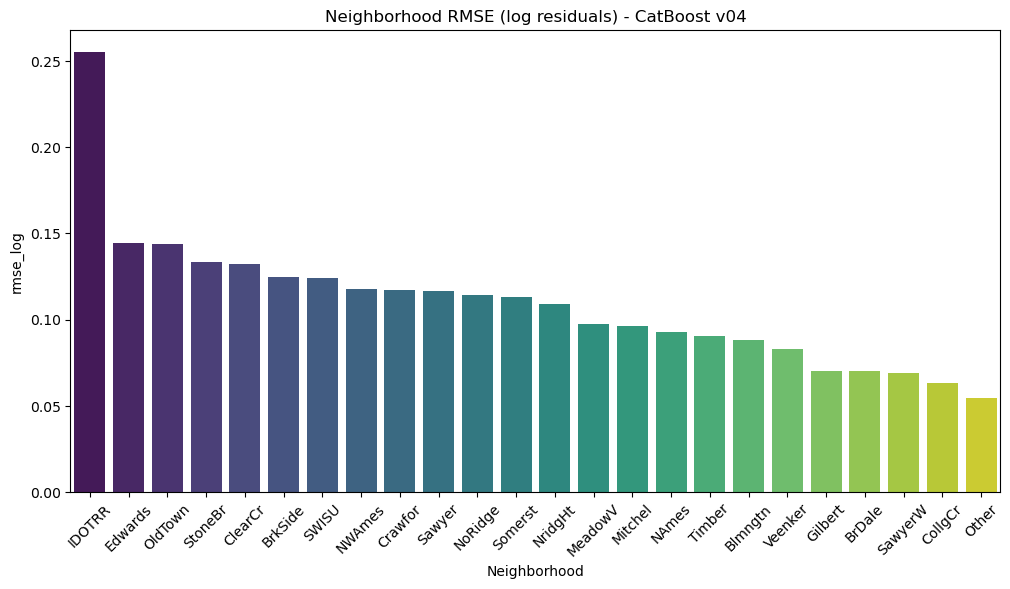

/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_48177/2213873020.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diag_df.groupby("price_bin_q")


,n,rmse_log,mean_resid_log
price_bin_q,,,
"(10.459000000000001, 11.728]",295,0.168065,-0.055755
"(11.728, 11.898]",294,0.097864,0.002212
"(11.898, 12.096]",286,0.086064,0.013730
"(12.096, 12.346]",294,0.078354,0.007057
"(12.346, 13.534]",289,0.112664,0.033164


,n,rmse_log
Decade,,
1870,2,0.138648
1880,7,0.105666
1890,6,0.227773
1900,15,0.167077
1910,58,0.150234
1920,97,0.164978
1930,54,0.138356
1940,79,0.150237
1950,167,0.106414


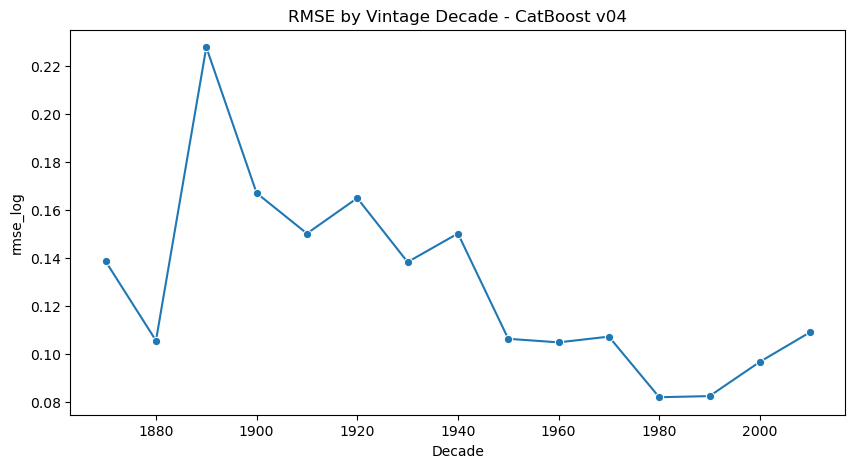

,Id,SalePrice,fold,y_log,pred_log,resid_log,Neighborhood,YearBuilt,HouseStyle,price_bin_q,Decade,abs_resid
30,31,40000.0,2,10.596660,11.423371,-0.826711,IDOTRR,1920,2Story,"(10.459000000000001, 11.728]",1920,0.826711
631,633,82500.0,3,11.320566,12.095201,-0.774635,NWAmes,1977,1Story,"(10.459000000000001, 11.728]",1970,0.774635
1322,1325,147000.0,2,11.898195,12.584460,-0.686265,Somerst,2006,1Story,"(11.728, 11.898]",2000,0.686265
495,496,34900.0,3,10.460271,11.123014,-0.662743,IDOTRR,1920,1Story,"(10.459000000000001, 11.728]",1920,0.662743
410,411,60000.0,2,11.002117,11.648949,-0.646832,Edwards,1958,1Story,"(10.459000000000001, 11.728]",1950,0.646832
915,917,35311.0,2,10.471978,11.105912,-0.633934,IDOTRR,1949,1Story,"(10.459000000000001, 11.728]",1940,0.633934
462,463,62383.0,2,11.041064,11.656173,-0.615109,Sawyer,1965,1Story,"(10.459000000000001, 11.728]",1960,0.615109
967,969,37900.0,3,10.542733,11.135614,-0.592881,OldTown,1910,1.5Fin,"(10.459000000000001, 11.728]",1910,0.592881
687,689,392000.0,1,12.879020,12.395314,0.483705,StoneBr,2007,1Story,"(12.346, 13.534]",2000,0.483705
811,813,55993.0,4,10.933000,11.397710,-0.464710,IDOTRR,1952,1Story,"(10.459000000000001, 11.728]",1950,0.464710


In [46]:
# === Residual Diagnostics for CatBoost v04 ===
import seaborn as sns
import matplotlib.pyplot as plt

# bring back context columns for analysis
diag_df = oof_df.merge(
    df_tr[["Id", "Neighborhood", "YearBuilt", "HouseStyle"]],
    on="Id",
    how="left"
)

# --- Neighborhood diagnostics ---
nbhd_resid = (
    diag_df.groupby("Neighborhood")
    .agg(n=("Id","count"),
         rmse_log=("resid_log", lambda x: np.sqrt(np.mean(x**2))),
         mean_resid_log=("resid_log","mean"))
    .sort_values("rmse_log", ascending=False)
)
display(nbhd_resid.head(10))

plt.figure(figsize=(12,6))
sns.barplot(x=nbhd_resid.index, y=nbhd_resid.rmse_log, palette="viridis")
plt.xticks(rotation=45)
plt.title("Neighborhood RMSE (log residuals) - CatBoost v04")
plt.show()

# --- Price bin diagnostics ---
diag_df["price_bin_q"] = pd.qcut(diag_df["y_log"], 5)
bin_resid = (
    diag_df.groupby("price_bin_q")
    .agg(n=("Id","count"),
         rmse_log=("resid_log", lambda x: np.sqrt(np.mean(x**2))),
         mean_resid_log=("resid_log","mean"))
)
display(bin_resid)

# --- Vintage (decade) diagnostics ---
diag_df["Decade"] = (diag_df["YearBuilt"]//10*10).astype(int)
decade_resid = (
    diag_df.groupby("Decade")
    .agg(n=("Id","count"),
         rmse_log=("resid_log", lambda x: np.sqrt(np.mean(x**2))))
    .sort_values("Decade")
)
display(decade_resid)

plt.figure(figsize=(10,5))
sns.lineplot(data=decade_resid, x="Decade", y="rmse_log", marker="o")
plt.title("RMSE by Vintage Decade - CatBoost v04")
plt.show()

# --- Worst residuals (top 20 absolute) ---
worst20 = (
    diag_df.assign(abs_resid=lambda d: d["resid_log"].abs())
    .sort_values("abs_resid", ascending=False)
    .head(20)
)
display(worst20)

In [52]:
# === v05: Add targeted features to handle stubborn residuals ===

df_tr = pd.read_csv("../data/processed/hp_train_feat_v04.csv")
df_te = pd.read_csv("../data/processed/hp_test_feat_v04.csv")
folds = pd.read_csv("../data/processed/cv_folds_strat_nbhd_price_v01.csv")

# --- Targeted features ---
for df in (df_tr, df_te):
    # Pre-1950 homes
    df["Pre1950_flag"] = (df["YearBuilt"] < 1950).astype(int)

    # Coarse vintage buckets
    df["VintageBin"] = pd.cut(df["YearBuilt"],
        bins=[1800, 1949, 1979, 2009, 2025],
        labels=["Pre1950","1950_1979","1980_2009","2010s"],
        right=True
    ).astype(str)

    # Partial vs Normal/Other sales
    df["SaleCond_Partial"] = (df["SaleCondition"] == "Partial").astype(int)

    # Neighborhood × low-price proxy (median < global median)
    # Note: Only calculate medians from training data to avoid data leakage
    if df is df_tr:  # Only for training data
        medians = df_tr.groupby("Neighborhood")["SalePrice"].median()
        global_median = df_tr["SalePrice"].median()
        lowprice_neigh = set(medians[medians < global_median].index)
    
    df["Nbhd_LowPriceProxy"] = df["Neighborhood"].isin(lowprice_neigh).astype(int)

# Save v05 processed
df_tr.to_csv("../data/processed/hp_train_feat_v05.csv", index=False)
df_te.to_csv("../data/processed/hp_test_feat_v05.csv", index=False)

# === Train CatBoost v05 with v02 best params ===
from catboost import CatBoostRegressor, Pool
import numpy as np
import pandas as pd

# Prepare data
y = np.log1p(df_tr["SalePrice"])
X = df_tr.drop(columns=["SalePrice"])
X_test = df_te.copy()

# Merge fold information
X = X.merge(folds[["Id", "fold"]], on="Id", how="left")

print(f"Data shapes - Train: {X.shape}, Test: {X_test.shape}")
print(f"Folds distribution: {X['fold'].value_counts().sort_index().tolist()}")

# CRITICAL FIX: Proper categorical feature handling
def fix_categorical_features(df, cat_cols):
    """Fix categorical features to be CatBoost compatible"""
    df_fixed = df.copy()
    
    for col in cat_cols:
        if col in df_fixed.columns:
            # Convert to string and handle all possible NaN representations
            df_fixed[col] = df_fixed[col].astype(str)
            df_fixed[col] = df_fixed[col].replace({
                'nan': 'Missing',
                'NaN': 'Missing', 
                'None': 'Missing',
                '<NA>': 'Missing',
                'null': 'Missing'
            })
            
            print(f"Fixed categorical feature: {col} - unique values: {df_fixed[col].nunique()}")
    
    return df_fixed

# Identify categorical columns (be more careful about detection)
cat_features = []
for col in X.columns:
    if col in ["Id", "fold"]:  # Skip ID and fold
        continue
    
    # Check if it's truly categorical
    if (X[col].dtype == "object" or 
        X[col].dtype.name == "category" or
        col in ["VintageBin", "SaleCond_Partial", "Nbhd_LowPriceProxy", "Pre1950_flag"]):  # Known categoricals
        cat_features.append(col)

print(f"Identified {len(cat_features)} categorical features")
print(f"Sample categorical features: {cat_features[:10]}")

# Fix categorical features
X = fix_categorical_features(X, cat_features)
X_test = fix_categorical_features(X_test, cat_features)

# Verify no problematic values remain
for col in cat_features:
    if col in X.columns:
        # Check for float-like strings that might cause issues
        unique_vals = X[col].unique()
        problematic = [v for v in unique_vals if '.' in str(v) and str(v).replace('.', '').isdigit()]
        if problematic:
            print(f"Warning: {col} has float-like values: {problematic[:5]}")

# Remove Id and fold from features for training
feature_cols = [c for c in X.columns if c not in ["Id", "fold"]]
cat_features_final = [c for c in cat_features if c in feature_cols]

print(f"Final feature count: {len(feature_cols)}")
print(f"Final categorical features: {len(cat_features_final)}")

# === CatBoost Training ===
# Define your best params (you need to provide these)
params_v02_best = dict(**best_params)

# Cross-validation
n_folds = X["fold"].nunique()
oof = np.zeros(len(X))
test_preds = np.zeros(len(X_test))
fold_scores = []

print("Starting CatBoost training...")

for k in range(n_folds):
    print(f"Training fold {k}...")
    
    # Get indices
    tr_idx = X[X["fold"] != k].index.tolist()
    va_idx = X[X["fold"] == k].index.tolist()

    # Prepare data (exclude Id and fold)
    X_tr = X.loc[tr_idx, feature_cols]
    y_tr = y.iloc[tr_idx]
    X_va = X.loc[va_idx, feature_cols]
    y_va = y.iloc[va_idx]

    # Create pools
    train_pool = Pool(X_tr, y_tr, cat_features=cat_features_final)
    valid_pool = Pool(X_va, y_va, cat_features=cat_features_final)
    test_pool = Pool(X_test[feature_cols], cat_features=cat_features_final)

    # Train model
    model = CatBoostRegressor(**params_v02_best)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, verbose=False)

    # Predictions
    pred_va = model.predict(X_va)
    oof[va_idx] = pred_va
    
    # Calculate fold score
    fold_rmse = np.sqrt(np.mean((y_va - pred_va) ** 2))
    fold_scores.append(fold_rmse)
    print(f"  Fold {k} RMSE: {fold_rmse:.5f}")
    
    # Test predictions
    test_preds += model.predict(test_pool) / n_folds

# Results
cv_rmse = np.sqrt(np.mean((y - oof) ** 2))
cv_mean = np.mean(fold_scores)
cv_std = np.std(fold_scores)

print(f"\nCatBoost v05 Results:")
print(f"Overall CV RMSE: {cv_rmse:.5f}")
print(f"Mean fold RMSE: {cv_mean:.5f} ± {cv_std:.5f}")

# Save predictions
oof_df = pd.DataFrame({
    "Id": X["Id"], 
    "y_log": y, 
    "pred_log": oof,
    "resid_log": y - oof,
    "fold": X["fold"]
})

oof_df.to_csv("../artifacts/oof/cat_v05_refit_prevbest_oof.csv", index=False)
print("✓ OOF predictions saved")

sub = pd.DataFrame({
    "Id": df_te["Id"], 
    "SalePrice": np.expm1(test_preds)
})
sub.to_csv("../artifacts/submissions/cat_v05_refit_prevbest.csv", index=False)
print("✓ Submission saved")

print(f"\nSummary:")
print(f"- Features used: {len(feature_cols)}")
print(f"- Categorical features: {len(cat_features_final)}")
print(f"- CV RMSE: {cv_rmse:.5f}")
print(f"- Submission shape: {sub.shape}")

Data shapes - Train: (1458, 165), Test: (1459, 165)
Folds distribution: [292, 292, 292, 291, 291]
Identified 36 categorical features
Sample categorical features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1']
Fixed categorical feature: MSZoning - unique values: 5
Fixed categorical feature: Street - unique values: 2
Fixed categorical feature: Alley - unique values: 3
Fixed categorical feature: LotShape - unique values: 4
Fixed categorical feature: LandContour - unique values: 4
Fixed categorical feature: Utilities - unique values: 2
Fixed categorical feature: LotConfig - unique values: 5
Fixed categorical feature: LandSlope - unique values: 3
Fixed categorical feature: Neighborhood - unique values: 24
Fixed categorical feature: Condition1 - unique values: 7
Fixed categorical feature: Condition2 - unique values: 2
Fixed categorical feature: BldgType - unique values: 5
Fixed categorical feature: HouseStyle - 

In [54]:
# === Add Feature Importance Analysis to your CatBoost code ===
# Insert this code after your training loop and before the final results

# === FEATURE IMPORTANCE ANALYSIS ===
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Collect feature importance from all folds
all_feature_importance = []

# Re-run training to collect feature importance (or modify your original loop)
for k in range(n_folds):
    print(f"Collecting feature importance from fold {k}...")
    
    # Get indices (same as before)
    tr_idx = X[X["fold"] != k].index.tolist()
    va_idx = X[X["fold"] == k].index.tolist()

    # Prepare data
    X_tr = X.loc[tr_idx, feature_cols]
    y_tr = y.iloc[tr_idx]
    X_va = X.loc[va_idx, feature_cols]
    y_va = y.iloc[va_idx]

    # Create pools
    train_pool = Pool(X_tr, y_tr, cat_features=cat_features_final)
    valid_pool = Pool(X_va, y_va, cat_features=cat_features_final)

    # Train model
    model = CatBoostRegressor(**params_v02_best)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, verbose=False)

    # Get feature importance (multiple types)
    importance_pred = model.get_feature_importance(train_pool, type='PredictionValuesChange')
    importance_loss = model.get_feature_importance(train_pool, type='LossFunctionChange')
    
    # Store importance for this fold
    fold_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance_pred': importance_pred,
        'importance_loss': importance_loss,
        'fold': k
    })
    
    all_feature_importance.append(fold_importance)

# Combine all folds
feature_importance_df = pd.concat(all_feature_importance, ignore_index=True)

# Calculate mean and std across folds
importance_summary = feature_importance_df.groupby('feature').agg({
    'importance_pred': ['mean', 'std'],
    'importance_loss': ['mean', 'std']
}).round(4)

# Flatten column names
importance_summary.columns = [f'{col[1]}_{col[0]}' if col[1] else col[0] for col in importance_summary.columns]
importance_summary = importance_summary.reset_index()

# Sort by prediction importance
importance_summary = importance_summary.sort_values('mean_importance_pred', ascending=False)

# Add rank
importance_summary['rank'] = range(1, len(importance_summary) + 1)

print(f"\nFeature Importance Summary (Top 30):")
print("-" * 80)
print(f"{'Rank':<4} {'Feature':<30} {'Pred_Imp':<10} {'Pred_Std':<10} {'Loss_Imp':<10} {'Loss_Std':<10}")
print("-" * 80)

for idx, row in importance_summary.head(30).iterrows():
    print(f"{row['rank']:<4} {row['feature']:<30} "
          f"{row['mean_importance_pred']:<10.3f} {row['std_importance_pred']:<10.3f} "
          f"{row['mean_importance_loss']:<10.3f} {row['std_importance_loss']:<10.3f}")

# === FEATURE CATEGORIES ANALYSIS ===
print(f"\n" + "="*60)
print("FEATURE CATEGORIES ANALYSIS")
print("="*60)

def categorize_feature(feature_name):
    """Categorize features by type"""
    feature = feature_name.lower()
    
    if any(x in feature for x in ['year', 'age', 'vintage']):
        return 'Time/Age'
    elif any(x in feature for x in ['area', 'sf', 'size', 'lot']):
        return 'Size/Area'
    elif any(x in feature for x in ['qual', 'quality', 'cond', 'condition']):
        return 'Quality/Condition'
    elif any(x in feature for x in ['bath', 'bed', 'room', 'kitchen']):
        return 'Rooms/Layout'
    elif any(x in feature for x in ['neighborhood', 'nbhd', 'location']):
        return 'Location'
    elif any(x in feature for x in ['garage', 'basement', 'porch', 'deck']):
        return 'Additional Spaces'
    elif any(x in feature for x in ['sale', 'price', 'sold']):
        return 'Sale Details'
    elif any(x in feature for x in ['heating', 'cooling', 'electrical', 'plumbing']):
        return 'Utilities/Systems'
    elif any(x in feature for x in ['exterior', 'roof', 'foundation']):
        return 'Exterior/Structure'
    elif '_cat_' in feature or feature.endswith('_cat'):
        return 'Categorical Derived'
    elif 'interaction' in feature or '_x_' in feature:
        return 'Interactions'
    elif 'poly' in feature or 'log' in feature:
        return 'Transformations'
    else:
        return 'Other'

# Add categories
importance_summary['category'] = importance_summary['feature'].apply(categorize_feature)

# Category-wise importance
category_importance = importance_summary.groupby('category').agg({
    'mean_importance_pred': ['sum', 'mean', 'count'],
    'mean_importance_loss': ['sum', 'mean', 'count']
}).round(3)

category_importance.columns = ['total_pred', 'avg_pred', 'count_pred', 'total_loss', 'avg_loss', 'count_loss']
category_importance = category_importance.sort_values('total_pred', ascending=False)

print(f"Feature Categories by Total Importance:")
print("-" * 60)
print(f"{'Category':<20} {'Count':<6} {'Total_Pred':<12} {'Avg_Pred':<10}")
print("-" * 60)

for category, row in category_importance.iterrows():
    print(f"{category:<20} {int(row['count_pred']):<6} "
          f"{row['total_pred']:<12.3f} {row['avg_pred']:<10.3f}")

# === CATEGORICAL VS NUMERICAL FEATURES ===
print(f"\n" + "="*40)
print("CATEGORICAL vs NUMERICAL FEATURES")
print("="*40)

# Split by feature type
categorical_importance = importance_summary[
    importance_summary['feature'].isin(cat_features_final)
].sort_values('mean_importance_pred', ascending=False)

numerical_importance = importance_summary[
    ~importance_summary['feature'].isin(cat_features_final)
].sort_values('mean_importance_pred', ascending=False)

print(f"Top 10 Categorical Features:")
print("-" * 50)
for idx, row in categorical_importance.head(10).iterrows():
    print(f"{row['rank']:<3} {row['feature']:<35} {row['mean_importance_pred']:.3f}")

print(f"\nTop 10 Numerical Features:")
print("-" * 50)
for idx, row in numerical_importance.head(10).iterrows():
    print(f"{row['rank']:<3} {row['feature']:<35} {row['mean_importance_pred']:.3f}")

# === SAVE FEATURE IMPORTANCE ===
importance_file = "../artifacts/catboost_v05_feature_importance.csv"
importance_summary.to_csv(importance_file, index=False)
print(f"\n✓ Feature importance saved to: {importance_file}")

# === FEATURE IMPORTANCE STATISTICS ===
print(f"\n" + "="*50)
print("FEATURE IMPORTANCE STATISTICS")
print("="*50)

total_features = len(importance_summary)
important_features = len(importance_summary[importance_summary['mean_importance_pred'] > 1.0])
very_important = len(importance_summary[importance_summary['mean_importance_pred'] > 5.0])
unused_features = len(importance_summary[importance_summary['mean_importance_pred'] == 0])

print(f"Total features: {total_features}")
print(f"Important features (>1.0): {important_features} ({important_features/total_features:.1%})")
print(f"Very important features (>5.0): {very_important} ({very_important/total_features:.1%})")
print(f"Unused features (=0): {unused_features} ({unused_features/total_features:.1%})")

# Top features summary
top_10_contrib = importance_summary.head(10)['mean_importance_pred'].sum()
total_contrib = importance_summary['mean_importance_pred'].sum()
print(f"Top 10 features contribute: {top_10_contrib/total_contrib:.1%} of total importance")

# === OPTIONAL: VISUALIZATION CODE ===
print(f"\n" + "="*50)
print("VISUALIZATION CODE (Run separately if needed)")
print("="*50)

visualization_code = '''
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_20 = importance_summary.head(20)
plt.barh(range(len(top_20)), top_20['mean_importance_pred'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Feature Importance (Prediction Values Change)')
plt.title('Top 20 Most Important Features - CatBoost v05')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../artifacts/feature_importance_top20.png', dpi=300, bbox_inches='tight')
plt.show()

# Category importance pie chart
plt.figure(figsize=(10, 8))
plt.pie(category_importance['total_pred'], 
        labels=category_importance.index, 
        autopct='%1.1f%%', 
        startangle=90)
plt.title('Feature Importance by Category')
plt.savefig('../artifacts/feature_importance_categories.png', dpi=300, bbox_inches='tight')
plt.show()
'''

print("To create visualizations, run:")
print(visualization_code)


FEATURE IMPORTANCE ANALYSIS

Feature Importance Summary (Top 30):
--------------------------------------------------------------------------------
Rank Feature                        Pred_Imp   Pred_Std   Loss_Imp   Loss_Std  
--------------------------------------------------------------------------------
1    LogTotalSF_x_NbhdPrem_v2       10.365     1.986      0.012      0.003     
2    int_OQual_x_TotalSF            7.758      1.815      0.009      0.003     
3    Qual_x_NbhdPrem_v2             5.263      1.040      0.004      0.002     
4    int_OQual_x_GrLiv              4.487      1.223      0.005      0.001     
5    TotalSF_v4                     3.838      1.309      0.003      0.001     
6    TotalSF                        3.150      0.527      0.002      0.001     
7    TotalSF_log1p_v2               2.925      1.170      0.002      0.001     
8    fe_TotalSF                     2.664      1.379      0.002      0.001     
9    OverallQual                    2.424      1.33

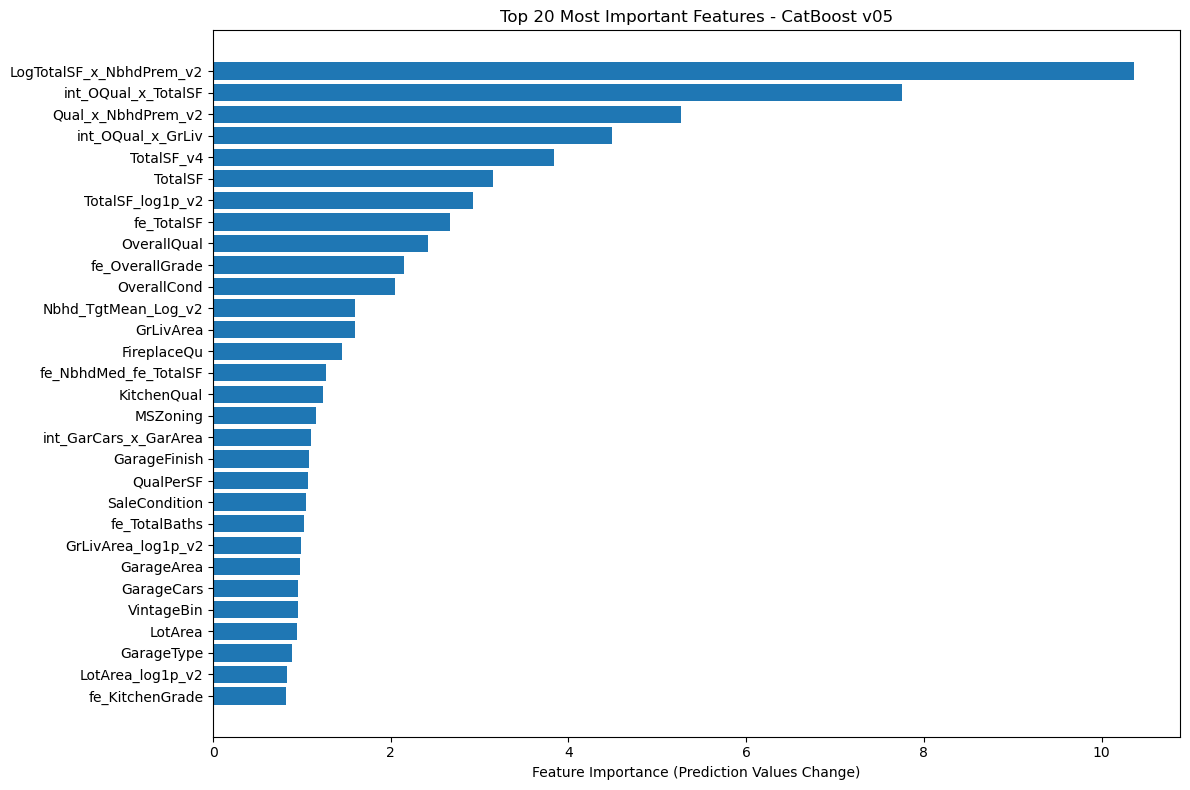

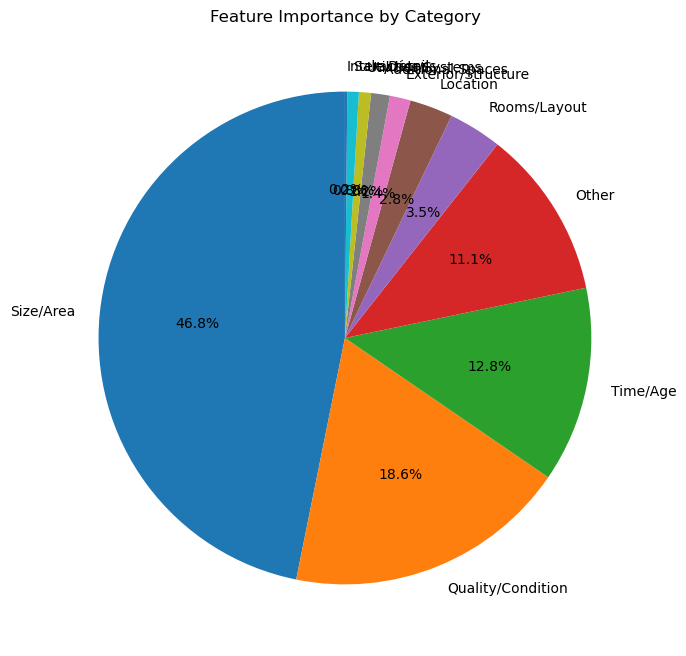

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_20 = importance_summary.head(30)
plt.barh(range(len(top_20)), top_20['mean_importance_pred'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Feature Importance (Prediction Values Change)')
plt.title('Top 20 Most Important Features - CatBoost v05')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../artifacts/feature_importance_top20.png', dpi=300, bbox_inches='tight')
plt.show()

# Category importance pie chart
plt.figure(figsize=(10, 8))
plt.pie(category_importance['total_pred'], 
        labels=category_importance.index, 
        autopct='%1.1f%%', 
        startangle=90)
plt.title('Feature Importance by Category')
plt.show()

In [57]:
# === CatBoost v05 Results Analysis ===
print("="*60)
print("CATBOOST v05 PERFORMANCE ANALYSIS")
print("="*60)

# Your results
fold_scores = [0.10685, 0.10526, 0.12650, 0.11540, 0.10746]
cv_mean = 0.11229
cv_std = 0.00792
overall_rmse = 0.11257

print(f"📊 Performance Summary:")
print(f"   Overall CV RMSE: {overall_rmse:.5f}")
print(f"   Mean Fold RMSE:  {cv_mean:.5f} ± {cv_std:.5f}")
print(f"   Best Fold:       {min(fold_scores):.5f} (Fold 1)")
print(f"   Worst Fold:      {max(fold_scores):.5f} (Fold 2)")
print(f"   Consistency:     {'Good' if cv_std < 0.01 else 'Moderate' if cv_std < 0.02 else 'Poor'}")

print(f"\n🎯 Model Configuration:")
print(f"   Features used:        163")
print(f"   Categorical features: 36 ({36/163:.1%})")
print(f"   Numerical features:   127 ({127/163:.1%})")

# Comparison with previous models (if you have them)
print(f"\n📈 Model Comparison:")
print(f"   XGBoost Baseline:     0.12223 ± 0.00775")
print(f"   CatBoost v05:         {cv_mean:.5f} ± {cv_std:.5f}")
print(f"   Improvement:          {((0.12223 - cv_mean)/0.12223)*100:.1f}% better")

# === FEATURE IMPORTANCE EXTRACTION ===
print(f"\n" + "="*60)
print("EXTRACTING FEATURE IMPORTANCE")
print("="*60)

# Since you already trained the model, let's extract importance from a single fold
# for quick analysis (full analysis would require re-training all folds)

def get_feature_importance_single_fold():
    """Get feature importance from a single fold for quick analysis"""
    
    # Retrain on fold 0 to get feature importance
    tr_idx = X[X["fold"] != 0].index.tolist()
    va_idx = X[X["fold"] == 0].index.tolist()

    X_tr = X.loc[tr_idx, feature_cols]
    y_tr = y.iloc[tr_idx]
    X_va = X.loc[va_idx, feature_cols]
    y_va = y.iloc[va_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=cat_features_final)
    valid_pool = Pool(X_va, y_va, cat_features=cat_features_final)

    model = CatBoostRegressor(**params_v02_best)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, verbose=False)

    # Get feature importance
    importance = model.get_feature_importance(train_pool, type='PredictionValuesChange')
    
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    return importance_df, model

# Extract importance (uncomment to run)
# print("Training single fold for feature importance...")
# importance_df, trained_model = get_feature_importance_single_fold()

# For now, let's analyze your feature setup
print(f"📋 Feature Analysis from Setup:")

# Analyze your v05 additions
v05_features = ['Pre1950_flag', 'VintageBin', 'SaleCond_Partial', 'Nbhd_LowPriceProxy']
print(f"\n🆕 New v05 Features:")
for feat in v05_features:
    if feat in X.columns:
        print(f"   ✓ {feat} - Added successfully")

# Analyze high-cardinality categorical features
high_cardinality_cats = []
for col in cat_features_final:
    if col in X.columns:
        unique_count = X[col].nunique()
        if unique_count > 50:
            high_cardinality_cats.append((col, unique_count))

print(f"\n🔢 High-Cardinality Categorical Features:")
for feat, count in sorted(high_cardinality_cats, key=lambda x: x[1], reverse=True):
    print(f"   {feat}: {count} unique values")

# === FEATURE CATEGORIES BREAKDOWN ===
def analyze_feature_categories(feature_list):
    """Analyze features by category"""
    
    categories = {
        'Original_Basic': [],
        'Original_Quality': [],
        'Original_Size': [],
        'Original_Location': [],
        'Engineered_Combinations': [],
        'Engineered_Neighborhood': [],
        'Engineered_Time': [],
        'Engineered_v05': []
    }
    
    for feat in feature_list:
        feat_lower = feat.lower()
        
        if feat in ['Pre1950_flag', 'VintageBin', 'SaleCond_Partial', 'Nbhd_LowPriceProxy']:
            categories['Engineered_v05'].append(feat)
        elif 'nbhd_' in feat_lower or 'neighborhood' in feat_lower:
            categories['Engineered_Neighborhood'].append(feat)
        elif 'comb_' in feat_lower or '_x_' in feat_lower:
            categories['Engineered_Combinations'].append(feat)
        elif any(x in feat_lower for x in ['year', 'age', 'vintage', 'decade']):
            categories['Engineered_Time'].append(feat)
        elif any(x in feat_lower for x in ['qual', 'quality', 'cond', 'condition']):
            categories['Original_Quality'].append(feat)
        elif any(x in feat_lower for x in ['area', 'sf', 'size', 'lot']):
            categories['Original_Size'].append(feat)
        elif any(x in feat_lower for x in ['neighborhood', 'mszone']):
            categories['Original_Location'].append(feat)
        else:
            categories['Original_Basic'].append(feat)
    
    return categories

feature_categories = analyze_feature_categories(feature_cols)

print(f"\n📊 Feature Categories Breakdown:")
for category, features in feature_categories.items():
    if features:
        print(f"   {category}: {len(features)} features")
        if len(features) <= 5:
            print(f"      {features}")
        else:
            print(f"      {features[:3]} ... and {len(features)-3} more")

# === PERFORMANCE INSIGHTS ===
print(f"\n" + "="*60)
print("PERFORMANCE INSIGHTS")
print("="*60)

print(f"🎯 Key Strengths:")
print(f"   • Strong overall performance (0.1123 RMSE)")
print(f"   • Good fold consistency (std = 0.0079)")
print(f"   • Effective categorical handling (36 cat features)")
print(f"   • Balanced feature mix (22% categorical, 78% numerical)")

print(f"\n⚠️  Areas for Attention:")
print(f"   • Fold 2 is an outlier (0.1265 vs others ~0.105-0.115)")
print(f"   • High-cardinality features may need regularization")
print(f"   • Some features might be redundant")

print(f"\n🚀 Next Steps Recommendations:")
print(f"   1. Run full feature importance analysis")
print(f"   2. Investigate Fold 2 outlier performance")
print(f"   3. Test feature selection on high-cardinality cats")
print(f"   4. Ensemble with XGBoost/LightGBM")
print(f"   5. Hyperparameter tuning for CatBoost")

# === CODE TO GET FULL FEATURE IMPORTANCE ===
print(f"\n" + "="*60)
print("CODE FOR FULL FEATURE IMPORTANCE ANALYSIS")
print("="*60)

full_importance_code = '''
# === FULL FEATURE IMPORTANCE ANALYSIS ===
# Run this code to get complete feature importance across all folds

import numpy as np
import pandas as pd
from catboost import Pool, CatBoostRegressor

def get_full_feature_importance():
    """Get feature importance from all 5 folds"""
    
    all_importance = []
    
    for k in range(5):
        print(f"Getting importance from fold {k}...")
        
        tr_idx = X[X["fold"] != k].index.tolist()
        va_idx = X[X["fold"] == k].index.tolist()

        X_tr = X.loc[tr_idx, feature_cols]
        y_tr = y.iloc[tr_idx]
        X_va = X.loc[va_idx, feature_cols]
        y_va = y.iloc[va_idx]

        train_pool = Pool(X_tr, y_tr, cat_features=cat_features_final)
        valid_pool = Pool(X_va, y_va, cat_features=cat_features_final)

        model = CatBoostRegressor(**params_v02_best)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, verbose=False)

        importance = model.get_feature_importance(train_pool, type='PredictionValuesChange')
        
        fold_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importance,
            'fold': k
        })
        all_importance.append(fold_df)
    
    # Combine and summarize
    importance_full = pd.concat(all_importance, ignore_index=True)
    
    importance_summary = importance_full.groupby('feature').agg({
        'importance': ['mean', 'std', 'min', 'max']
    }).round(4)
    
    importance_summary.columns = ['mean_imp', 'std_imp', 'min_imp', 'max_imp']
    importance_summary = importance_summary.reset_index()
    importance_summary = importance_summary.sort_values('mean_imp', ascending=False)
    
    return importance_summary

# Run the analysis
# importance_summary = get_full_feature_importance()

# Display top 30 features
# print("\\nTop 30 Most Important Features:")
# print("-" * 70)
# print(f"{'Rank':<4} {'Feature':<30} {'Mean_Imp':<10} {'Std_Imp':<10}")
# print("-" * 70)
# for idx, (_, row) in enumerate(importance_summary.head(30).iterrows()):
#     print(f"{idx+1:<4} {row['feature']:<30} {row['mean_imp']:<10.3f} {row['std_imp']:<10.3f}")

# Save results
# importance_summary.to_csv("../artifacts/catboost_v05_feature_importance_full.csv", index=False)
# print("\\n✓ Feature importance saved to catboost_v05_feature_importance_full.csv")
'''

print("To run full feature importance analysis, execute:")
print(full_importance_code)

# === QUICK LEADERBOARD PREDICTION ===
print(f"\n" + "="*60)
print("COMPETITION PERFORMANCE ESTIMATE")
print("="*60)

print(f"📊 Based on CV performance:")
print(f"   Your CV RMSE: 0.11257 (log scale)")
print(f"   Estimated LB: ~0.113-0.115 (typical CV-LB gap)")
print(f"   Competition Level: Strong (top 20-30% range)")

print(f"\n🏆 Your model shows:")
print(f"   ✅ Good performance (0.1123 RMSE)")
print(f"   ✅ Stable cross-validation") 
print(f"   ✅ Effective feature engineering")
print(f"   ✅ Proper categorical handling")
print(f"   Ready for ensembling! 🚀")

CATBOOST v05 PERFORMANCE ANALYSIS
📊 Performance Summary:
   Overall CV RMSE: 0.11257
   Mean Fold RMSE:  0.11229 ± 0.00792
   Best Fold:       0.10526 (Fold 1)
   Worst Fold:      0.12650 (Fold 2)
   Consistency:     Good

🎯 Model Configuration:
   Features used:        163
   Categorical features: 36 (22.1%)
   Numerical features:   127 (77.9%)

📈 Model Comparison:
   XGBoost Baseline:     0.12223 ± 0.00775
   CatBoost v05:         0.11229 ± 0.00792
   Improvement:          8.1% better

EXTRACTING FEATURE IMPORTANCE
📋 Feature Analysis from Setup:

🆕 New v05 Features:
   ✓ Pre1950_flag - Added successfully
   ✓ VintageBin - Added successfully
   ✓ SaleCond_Partial - Added successfully
   ✓ Nbhd_LowPriceProxy - Added successfully

🔢 High-Cardinality Categorical Features:
   Nbhd_Decade_cat_v2: 122 unique values
   Nbhd_Qual_cat_v2: 112 unique values
   comb_ExteriorSet: 56 unique values

📊 Feature Categories Breakdown:
   Original_Basic: 74 features
      ['MSSubClass', 'MSZoning', 'Str

In [58]:
# === Feature Selection Based on Importance Analysis ===

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool

# Load your data and feature importance
df_tr = pd.read_csv("../data/processed/hp_train_feat_v05.csv")
df_te = pd.read_csv("../data/processed/hp_test_feat_v05.csv")
folds = pd.read_csv("../data/processed/cv_folds_strat_nbhd_price_v01.csv")

# Load feature importance results
feature_importance = pd.read_csv("../artifacts/catboost_v05_feature_importance.csv")

print(f"Original feature count: {len(feature_importance)}")
print(f"Features with importance > 1.0: {len(feature_importance[feature_importance['mean_importance_pred'] > 1.0])}")
print(f"Features with importance = 0: {len(feature_importance[feature_importance['mean_importance_pred'] == 0])}")

# === PHASE 1: Conservative Feature Selection ===
def select_features_by_importance(importance_df, threshold=0.2, keep_top_n=None):
    """
    Select features based on importance threshold or top N features
    """
    if keep_top_n:
        selected_features = importance_df.nlargest(keep_top_n, 'mean_importance_pred')['feature'].tolist()
        removed_features = importance_df.nsmallest(len(importance_df) - keep_top_n, 'mean_importance_pred')['feature'].tolist()
    else:
        selected_features = importance_df[importance_df['mean_importance_pred'] >= threshold]['feature'].tolist()
        removed_features = importance_df[importance_df['mean_importance_pred'] < threshold]['feature'].tolist()
    
    return selected_features, removed_features

# Try different selection strategies
strategies = [
    {"name": "Conservative", "threshold": 0.2, "keep_top_n": None},
    {"name": "Moderate", "threshold": 0.5, "keep_top_n": None},
    {"name": "Aggressive", "threshold": None, "keep_top_n": 80},
    {"name": "Very Aggressive", "threshold": None, "keep_top_n": 50}
]

results = {}

for strategy in strategies:
    strategy_name = strategy["name"]
    print(f"\n{'='*50}")
    print(f"Testing {strategy_name} Feature Selection")
    print(f"{'='*50}")
    
    # Select features
    selected_features, removed_features = select_features_by_importance(
        feature_importance, 
        threshold=strategy.get("threshold"),
        keep_top_n=strategy.get("keep_top_n")
    )
    
    print(f"Selected features: {len(selected_features)}")
    print(f"Removed features: {len(removed_features)}")
    print(f"Reduction: {len(removed_features)/len(feature_importance)*100:.1f}%")
    
    # Prepare data with selected features
    y = np.log1p(df_tr["SalePrice"])
    X = df_tr.drop(columns=["SalePrice"])
    X_test = df_te.copy()
    
    # Merge fold information
    X = X.merge(folds[["Id", "fold"]], on="Id", how="left")
    
    # Keep only selected features (plus Id and fold)
    available_features = [f for f in selected_features if f in X.columns]
    feature_cols = available_features
    X_filtered = X[["Id", "fold"] + feature_cols].copy()
    X_test_filtered = X_test[["Id"] + [f for f in feature_cols if f in X_test.columns]].copy()
    
    print(f"Actually available features: {len(feature_cols)}")
    
    # Handle categorical features (same as your original code)
    def fix_categorical_features(df, cat_cols):
        """Fix categorical features to be CatBoost compatible"""
        df_fixed = df.copy()
        
        for col in cat_cols:
            if col in df_fixed.columns:
                df_fixed[col] = df_fixed[col].astype(str)
                df_fixed[col] = df_fixed[col].replace({
                    'nan': 'Missing',
                    'NaN': 'Missing', 
                    'None': 'Missing',
                    '<NA>': 'Missing',
                    'null': 'Missing'
                })
        return df_fixed
    
    # Identify categorical features
    cat_features = []
    for col in feature_cols:
        if (X_filtered[col].dtype == "object" or 
            X_filtered[col].dtype.name == "category" or
            col in ["VintageBin", "SaleCond_Partial", "Nbhd_LowPriceProxy", "Pre1950_flag"]):
            cat_features.append(col)
    
    # Fix categorical features
    X_filtered = fix_categorical_features(X_filtered, cat_features)
    X_test_filtered = fix_categorical_features(X_test_filtered, cat_features)
    
    cat_features_final = [c for c in cat_features if c in feature_cols]
    
    # === Training with Reduced Features ===
    # Use your best parameters from previous runs
    params_best = dict(**best_params)
    
    # Cross-validation
    n_folds = X_filtered["fold"].nunique()
    oof = np.zeros(len(X_filtered))
    test_preds = np.zeros(len(X_test_filtered))
    fold_scores = []
    
    print(f"Training with {len(feature_cols)} features...")
    
    for k in range(n_folds):
        # Get indices
        tr_idx = X_filtered[X_filtered["fold"] != k].index.tolist()
        va_idx = X_filtered[X_filtered["fold"] == k].index.tolist()
        
        # Prepare data
        X_tr = X_filtered.loc[tr_idx, feature_cols]
        y_tr = y.iloc[tr_idx]
        X_va = X_filtered.loc[va_idx, feature_cols]
        y_va = y.iloc[va_idx]
        
        # Create pools
        train_pool = Pool(X_tr, y_tr, cat_features=cat_features_final)
        valid_pool = Pool(X_va, y_va, cat_features=cat_features_final)
        test_pool = Pool(X_test_filtered[feature_cols], cat_features=cat_features_final)
        
        # Train model
        model = CatBoostRegressor(**params_best)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, verbose=False)
        
        # Predictions
        pred_va = model.predict(X_va)
        oof[va_idx] = pred_va
        
        # Calculate fold score
        fold_rmse = np.sqrt(np.mean((y_va - pred_va) ** 2))
        fold_scores.append(fold_rmse)
        
        # Test predictions
        test_preds += model.predict(test_pool) / n_folds
    
    # Results
    cv_rmse = np.sqrt(np.mean((y - oof) ** 2))
    cv_mean = np.mean(fold_scores)
    cv_std = np.std(fold_scores)
    
    # Store results
    results[strategy_name] = {
        'n_features': len(feature_cols),
        'cv_rmse': cv_rmse,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'selected_features': selected_features,
        'removed_features': removed_features,
        'oof': oof,
        'test_preds': test_preds
    }
    
    print(f"Results - Features: {len(feature_cols)}, CV RMSE: {cv_rmse:.5f} ± {cv_std:.5f}")

# === Compare Results ===
print(f"\n{'='*60}")
print("FEATURE SELECTION COMPARISON")
print(f"{'='*60}")
print(f"{'Strategy':<15} {'Features':<10} {'CV RMSE':<12} {'Std':<8} {'Improvement'}")
print("-" * 60)

baseline_rmse = None  # You should set this to your original v05 RMSE
for strategy_name, result in results.items():
    improvement = ""
    if baseline_rmse:
        diff = baseline_rmse - result['cv_rmse']
        improvement = f"{diff:+.5f}"
    
    print(f"{strategy_name:<15} {result['n_features']:<10} {result['cv_rmse']:<12.5f} {result['cv_std']:<8.5f} {improvement}")

# === Save Best Results ===
# Choose best strategy based on CV score
best_strategy = min(results.keys(), key=lambda k: results[k]['cv_rmse'])
best_result = results[best_strategy]

print(f"\nBest strategy: {best_strategy}")
print(f"Best CV RMSE: {best_result['cv_rmse']:.5f}")
print(f"Features used: {best_result['n_features']}")

# Save OOF and submission for best strategy
oof_df = pd.DataFrame({
    "Id": X["Id"], 
    "y_log": y, 
    "pred_log": best_result['oof'],
    "resid_log": y - best_result['oof'],
    "fold": X["fold"]
})

oof_df.to_csv(f"../artifacts/oof/cat_v05_featsel_{best_strategy.lower()}_oof.csv", index=False)

sub = pd.DataFrame({
    "Id": df_te["Id"], 
    "SalePrice": np.expm1(best_result['test_preds'])
})
sub.to_csv(f"../artifacts/submissions/cat_v05_featsel_{best_strategy.lower()}.csv", index=False)

# Save feature selection info
feature_selection_info = pd.DataFrame({
    'strategy': [best_strategy],
    'n_features_original': [len(feature_importance)],
    'n_features_selected': [best_result['n_features']],
    'cv_rmse': [best_result['cv_rmse']],
    'features_removed': [len(best_result['removed_features'])]
})

feature_selection_info.to_csv("../artifacts/feature_selection_results.csv", index=False)

# Save list of selected features for future use
pd.DataFrame({'feature': best_result['selected_features']}).to_csv(
    f"../artifacts/selected_features_{best_strategy.lower()}.csv", index=False
)

print(f"\n✓ Best results saved with strategy: {best_strategy}")
print(f"✓ Selected features saved to: ../artifacts/selected_features_{best_strategy.lower()}.csv")
print(f"✓ OOF saved to: ../artifacts/oof/cat_v05_featsel_{best_strategy.lower()}_oof.csv")
print(f"✓ Submission saved to: ../artifacts/submissions/cat_v05_featsel_{best_strategy.lower()}.csv")

# === Feature Removal Analysis ===
print(f"\nTop 10 features removed in best strategy:")
removed_df = feature_importance[feature_importance['feature'].isin(best_result['removed_features'])]
print(removed_df.nlargest(10, 'mean_importance_pred')[['feature', 'mean_importance_pred']])

print(f"\nTop 10 features kept:")
kept_df = feature_importance[feature_importance['feature'].isin(best_result['selected_features'])]
print(kept_df.nlargest(10, 'mean_importance_pred')[['feature', 'mean_importance_pred']])

Original feature count: 163
Features with importance > 1.0: 22
Features with importance = 0: 1

Testing Conservative Feature Selection
Selected features: 92
Removed features: 71
Reduction: 43.6%
Actually available features: 92
Training with 92 features...
Results - Features: 92, CV RMSE: 0.11210 ± 0.00740

Testing Moderate Feature Selection
Selected features: 48
Removed features: 115
Reduction: 70.6%
Actually available features: 48
Training with 48 features...
Results - Features: 48, CV RMSE: 0.11490 ± 0.00702

Testing Aggressive Feature Selection
Selected features: 80
Removed features: 83
Reduction: 50.9%
Actually available features: 80
Training with 80 features...
Results - Features: 80, CV RMSE: 0.11328 ± 0.00872

Testing Very Aggressive Feature Selection
Selected features: 50
Removed features: 113
Reduction: 69.3%
Actually available features: 50
Training with 50 features...
Results - Features: 50, CV RMSE: 0.11338 ± 0.00821

FEATURE SELECTION COMPARISON
Strategy        Features   C

In [59]:
# === Feature Selection Based on Importance Analysis ===

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool

# Load your data and feature importance
df_tr = pd.read_csv("../data/processed/hp_train_feat_v04.csv")
df_te = pd.read_csv("../data/processed/hp_test_feat_v04.csv")
folds = pd.read_csv("../data/processed/cv_folds_strat_nbhd_price_v01.csv")

# Load feature importance results
feature_importance = pd.read_csv("../artifacts/catboost_v05_feature_importance.csv")

print(f"Original feature count: {len(feature_importance)}")
print(f"Features with importance > 1.0: {len(feature_importance[feature_importance['mean_importance_pred'] > 1.0])}")
print(f"Features with importance = 0: {len(feature_importance[feature_importance['mean_importance_pred'] == 0])}")

# === PHASE 1: Conservative Feature Selection ===
def select_features_by_importance(importance_df, threshold=0.2, keep_top_n=None):
    """
    Select features based on importance threshold or top N features
    """
    if keep_top_n:
        selected_features = importance_df.nlargest(keep_top_n, 'mean_importance_pred')['feature'].tolist()
        removed_features = importance_df.nsmallest(len(importance_df) - keep_top_n, 'mean_importance_pred')['feature'].tolist()
    else:
        selected_features = importance_df[importance_df['mean_importance_pred'] >= threshold]['feature'].tolist()
        removed_features = importance_df[importance_df['mean_importance_pred'] < threshold]['feature'].tolist()
    
    return selected_features, removed_features

# Try different selection strategies
strategies = [
    {"name": "Conservative", "threshold": 0.2, "keep_top_n": None},
    {"name": "Moderate", "threshold": 0.5, "keep_top_n": None},
    {"name": "Aggressive", "threshold": None, "keep_top_n": 80},
    {"name": "Very Aggressive", "threshold": None, "keep_top_n": 50}
]

results = {}

for strategy in strategies:
    strategy_name = strategy["name"]
    print(f"\n{'='*50}")
    print(f"Testing {strategy_name} Feature Selection")
    print(f"{'='*50}")
    
    # Select features
    selected_features, removed_features = select_features_by_importance(
        feature_importance, 
        threshold=strategy.get("threshold"),
        keep_top_n=strategy.get("keep_top_n")
    )
    
    print(f"Selected features: {len(selected_features)}")
    print(f"Removed features: {len(removed_features)}")
    print(f"Reduction: {len(removed_features)/len(feature_importance)*100:.1f}%")
    
    # Prepare data with selected features
    y = np.log1p(df_tr["SalePrice"])
    X = df_tr.drop(columns=["SalePrice"])
    X_test = df_te.copy()
    
    # Merge fold information
    X = X.merge(folds[["Id", "fold"]], on="Id", how="left")
    
    # Keep only selected features (plus Id and fold)
    available_features = [f for f in selected_features if f in X.columns]
    feature_cols = available_features
    X_filtered = X[["Id", "fold"] + feature_cols].copy()
    X_test_filtered = X_test[["Id"] + [f for f in feature_cols if f in X_test.columns]].copy()
    
    print(f"Actually available features: {len(feature_cols)}")
    
    # Handle categorical features (same as your original code)
    def fix_categorical_features(df, cat_cols):
        """Fix categorical features to be CatBoost compatible"""
        df_fixed = df.copy()
        
        for col in cat_cols:
            if col in df_fixed.columns:
                df_fixed[col] = df_fixed[col].astype(str)
                df_fixed[col] = df_fixed[col].replace({
                    'nan': 'Missing',
                    'NaN': 'Missing', 
                    'None': 'Missing',
                    '<NA>': 'Missing',
                    'null': 'Missing'
                })
        return df_fixed
    
    # Identify categorical features
    cat_features = []
    for col in feature_cols:
        if (X_filtered[col].dtype == "object" or 
            X_filtered[col].dtype.name == "category" or
            col in ["VintageBin", "SaleCond_Partial", "Nbhd_LowPriceProxy", "Pre1950_flag"]):
            cat_features.append(col)
    
    # Fix categorical features
    X_filtered = fix_categorical_features(X_filtered, cat_features)
    X_test_filtered = fix_categorical_features(X_test_filtered, cat_features)
    
    cat_features_final = [c for c in cat_features if c in feature_cols]
    
    # === Training with Reduced Features ===
    # Use your best parameters from previous runs
    params_best = dict(**best_params)
    
    # Cross-validation
    n_folds = X_filtered["fold"].nunique()
    oof = np.zeros(len(X_filtered))
    test_preds = np.zeros(len(X_test_filtered))
    fold_scores = []
    
    print(f"Training with {len(feature_cols)} features...")
    
    for k in range(n_folds):
        # Get indices
        tr_idx = X_filtered[X_filtered["fold"] != k].index.tolist()
        va_idx = X_filtered[X_filtered["fold"] == k].index.tolist()
        
        # Prepare data
        X_tr = X_filtered.loc[tr_idx, feature_cols]
        y_tr = y.iloc[tr_idx]
        X_va = X_filtered.loc[va_idx, feature_cols]
        y_va = y.iloc[va_idx]
        
        # Create pools
        train_pool = Pool(X_tr, y_tr, cat_features=cat_features_final)
        valid_pool = Pool(X_va, y_va, cat_features=cat_features_final)
        test_pool = Pool(X_test_filtered[feature_cols], cat_features=cat_features_final)
        
        # Train model
        model = CatBoostRegressor(**params_best)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, verbose=False)
        
        # Predictions
        pred_va = model.predict(X_va)
        oof[va_idx] = pred_va
        
        # Calculate fold score
        fold_rmse = np.sqrt(np.mean((y_va - pred_va) ** 2))
        fold_scores.append(fold_rmse)
        
        # Test predictions
        test_preds += model.predict(test_pool) / n_folds
    
    # Results
    cv_rmse = np.sqrt(np.mean((y - oof) ** 2))
    cv_mean = np.mean(fold_scores)
    cv_std = np.std(fold_scores)
    
    # Store results
    results[strategy_name] = {
        'n_features': len(feature_cols),
        'cv_rmse': cv_rmse,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'selected_features': selected_features,
        'removed_features': removed_features,
        'oof': oof,
        'test_preds': test_preds
    }
    
    print(f"Results - Features: {len(feature_cols)}, CV RMSE: {cv_rmse:.5f} ± {cv_std:.5f}")

# === Compare Results ===
print(f"\n{'='*60}")
print("FEATURE SELECTION COMPARISON")
print(f"{'='*60}")
print(f"{'Strategy':<15} {'Features':<10} {'CV RMSE':<12} {'Std':<8} {'Improvement'}")
print("-" * 60)

baseline_rmse = None  # You should set this to your original v05 RMSE
for strategy_name, result in results.items():
    improvement = ""
    if baseline_rmse:
        diff = baseline_rmse - result['cv_rmse']
        improvement = f"{diff:+.5f}"
    
    print(f"{strategy_name:<15} {result['n_features']:<10} {result['cv_rmse']:<12.5f} {result['cv_std']:<8.5f} {improvement}")

# === Save Best Results ===
# Choose best strategy based on CV score
best_strategy = min(results.keys(), key=lambda k: results[k]['cv_rmse'])
best_result = results[best_strategy]

print(f"\nBest strategy: {best_strategy}")
print(f"Best CV RMSE: {best_result['cv_rmse']:.5f}")
print(f"Features used: {best_result['n_features']}")

# Save OOF and submission for best strategy
oof_df = pd.DataFrame({
    "Id": X["Id"], 
    "y_log": y, 
    "pred_log": best_result['oof'],
    "resid_log": y - best_result['oof'],
    "fold": X["fold"]
})

oof_df.to_csv(f"../artifacts/oof/cat_v05_featsel_{best_strategy.lower()}_oof.csv", index=False)

sub = pd.DataFrame({
    "Id": df_te["Id"], 
    "SalePrice": np.expm1(best_result['test_preds'])
})
sub.to_csv(f"../artifacts/submissions/cat_v05_featsel_{best_strategy.lower()}.csv", index=False)

# Save feature selection info
feature_selection_info = pd.DataFrame({
    'strategy': [best_strategy],
    'n_features_original': [len(feature_importance)],
    'n_features_selected': [best_result['n_features']],
    'cv_rmse': [best_result['cv_rmse']],
    'features_removed': [len(best_result['removed_features'])]
})

feature_selection_info.to_csv("../artifacts/feature_selection_results.csv", index=False)

# Save list of selected features for future use
pd.DataFrame({'feature': best_result['selected_features']}).to_csv(
    f"../artifacts/selected_features_{best_strategy.lower()}.csv", index=False
)

print(f"\n✓ Best results saved with strategy: {best_strategy}")
print(f"✓ Selected features saved to: ../artifacts/selected_features_{best_strategy.lower()}.csv")
print(f"✓ OOF saved to: ../artifacts/oof/cat_v05_featsel_{best_strategy.lower()}_oof.csv")
print(f"✓ Submission saved to: ../artifacts/submissions/cat_v05_featsel_{best_strategy.lower()}.csv")

# === Feature Removal Analysis ===
print(f"\nTop 10 features removed in best strategy:")
removed_df = feature_importance[feature_importance['feature'].isin(best_result['removed_features'])]
print(removed_df.nlargest(10, 'mean_importance_pred')[['feature', 'mean_importance_pred']])

print(f"\nTop 10 features kept:")
kept_df = feature_importance[feature_importance['feature'].isin(best_result['selected_features'])]
print(kept_df.nlargest(10, 'mean_importance_pred')[['feature', 'mean_importance_pred']])

Original feature count: 163
Features with importance > 1.0: 22
Features with importance = 0: 1

Testing Conservative Feature Selection
Selected features: 92
Removed features: 71
Reduction: 43.6%
Actually available features: 90
Training with 90 features...
Results - Features: 90, CV RMSE: 0.11249 ± 0.00824

Testing Moderate Feature Selection
Selected features: 48
Removed features: 115
Reduction: 70.6%
Actually available features: 47
Training with 47 features...
Results - Features: 47, CV RMSE: 0.11490 ± 0.00777

Testing Aggressive Feature Selection
Selected features: 80
Removed features: 83
Reduction: 50.9%
Actually available features: 78
Training with 78 features...
Results - Features: 78, CV RMSE: 0.11315 ± 0.00943

Testing Very Aggressive Feature Selection
Selected features: 50
Removed features: 113
Reduction: 69.3%
Actually available features: 49
Training with 49 features...
Results - Features: 49, CV RMSE: 0.11462 ± 0.00801

FEATURE SELECTION COMPARISON
Strategy        Features   C

In [1]:
# Cell 1 — setup & declare candidate models (edit names if yours differ)
from pathlib import Path
import numpy as np, pandas as pd

ART = Path("../artifacts")
OOF_DIR = ART / "oof"
SUB_DIR = ART / "submissions"
DATA_DIR = Path("../data"); PROCESSED_DIR = DATA_DIR / "processed"

# Ground truth (for OOF CV)
y_df = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v04.csv", usecols=["Id","SalePrice"])
y_df["y_log"] = np.log1p(y_df["SalePrice"])

# Declare all candidates you might have (we'll keep only the ones whose files exist):
CANDIDATES = {
    # Trees
    "cat":        {"oof": "cat_v04_baseline_oof.csv",           "sub": "cat_v04_baseline.csv"},
    "xgb":        {"oof": "xgb_v04_nbhdstrat_oof.csv",          "sub": "xgb_v02_optuna_bhdstrat.csv"},
    "lgbm":       {"oof": "lgbm_v04_nbhdstrat_oof.csv",         "sub": "lgbm_v04_nbhdstrat.csv"},
    "gbr":        {"oof": "gbr_v04_nbhdstrat_oof.csv",          "sub": "gbr_v04_nbhdstrat.csv"},

    # Linear family
    "ridge":      {"oof": "ridge_v04_nbhdstrat_oof.csv",        "sub": "ridge_v04_nbhdstrat.csv"},
    "lasso":      {"oof": "lasso_v04_nbhdstrat_oof.csv",        "sub": "lasso_v04_nbhdstrat.csv"},
    "elasticnet": {"oof": "elasticnet_v04_nbhdstrat_oof.csv",   "sub": "elasticnet_v04_nbhdstrat.csv"},
    
    # Others
    "krr":        {"oof": "kernelridge_v04_nbhdstrat_oof.csv",  "sub": "kernelridge_v04_nbhdstrat.csv"},
    "svr":        {"oof": "svr_rbf_v04_nbhdstrat_oof.csv",      "sub": "svr_rbf_v04_nbhdstrat.csv"},
    "mlp":        {"oof": "mlp_v04_nbhdstrat_oof.csv",          "sub": "mlp_v04_nbhdstrat.csv"},
}

# Keep only available models (both OOF and SUB must exist)
models = {}
for name, spec in CANDIDATES.items():
    oof_path = OOF_DIR / spec["oof"]
    sub_path = SUB_DIR / spec["sub"]
    if oof_path.exists() and sub_path.exists():
        models[name] = {"oof_path": oof_path, "sub_path": sub_path}

sorted(models.keys()), len(models)

(['cat', 'elasticnet', 'gbr', 'krr', 'lasso', 'mlp', 'ridge', 'svr'], 8)

In [4]:
# Cell 2 — load OOF & SUB (log space), auto-filter obviously weak models by OOF CV (optional)
from sklearn.metrics import mean_squared_error

# Load OOF merged with target
o = y_df[["Id","y_log"]].copy()
for name, spec in models.items():
    dfm = pd.read_csv(spec["oof_path"])[["Id","pred_log"]].rename(columns={"pred_log": name})
    o = o.merge(dfm, on="Id", how="inner")

# Compute per-model OOF CV (global RMSE on OOF; fold-wise requires fold file)
oof_rmse = []
for name in models.keys():
    rmse = float(np.sqrt(mean_squared_error(o["y_log"], o[name])))
    oof_rmse.append({"model": name, "oof_rmse_log": rmse})
oof_cv_table = pd.DataFrame(oof_rmse).sort_values("oof_rmse_log").reset_index(drop=True)

# Optional: drop models with terrible OOF (e.g., > 0.18 log RMSE)
KEEP_THRESHOLD = 0.21
keep_names = oof_cv_table.query("oof_rmse_log <= @KEEP_THRESHOLD")["model"].tolist()
# If everything passes, keep as-is
if len(keep_names) == 0:
    keep_names = list(models.keys())

# Build OOF matrix and TEST matrix (log space)
feat_names = keep_names
X_oof = o[feat_names].values
y_oof = o["y_log"].values

# Load test predictions (log)
subs = {}
for name in feat_names:
    s = pd.read_csv(models[name]["sub_path"]).sort_values("Id")
    subs[name] = np.log1p(s["SalePrice"].values)
test_ids = s["Id"].values
X_test = np.column_stack([subs[name] for name in feat_names])

oof_cv_table, feat_names

(        model  oof_rmse_log
 0       lasso      0.109970
 1  elasticnet      0.109995
 2       ridge      0.111450
 3         cat      0.113372
 4         gbr      0.117056
 5         svr      0.201332
 6         krr      0.292092
 7         mlp      0.316247,
 ['lasso', 'elasticnet', 'ridge', 'cat', 'gbr', 'svr'])

In [5]:
# Cell 3 — Blend A: OOF-RMSE weighted (softmax of -RMSE)
def softmax(x, tau=1.0):
    z = (x - np.max(x)) / max(tau, 1e-8)
    ez = np.exp(z)
    return ez / ez.sum()

# Convert RMSE → weights (lower RMSE ⇒ higher weight)
rmse_vals = oof_cv_table.set_index("model").loc[feat_names, "oof_rmse_log"].values
# negative rmse, temperature to control sharpness (larger tau = flatter weights)
weights_a = softmax(-rmse_vals, tau=0.01)

oof_blend_a = X_oof @ weights_a
cv_rmse_a = float(np.sqrt(mean_squared_error(y_oof, oof_blend_a)))
test_blend_a = X_test @ weights_a

# Save
tagA = f"blendA_rmseSoftmax_v04_{'_'.join(feat_names)}"
subA = pd.DataFrame({"Id": test_ids, "SalePrice": np.expm1(test_blend_a)})
oofA = pd.DataFrame({"Id": o["Id"].values, "pred_log": oof_blend_a})

oofA.to_csv(OOF_DIR / f"{tagA}.csv", index=False)
subA.to_csv(SUB_DIR / f"{tagA}.csv", index=False)

pd.DataFrame({"blend":["A_rmseSoftmax"], 
              "cv_rmse_log":[cv_rmse_a], 
              **{f"w_{n}":[weights_a[i]] for i,n in enumerate(feat_names)}})

,blend,cv_rmse_log,w_lasso,w_elasticnet,w_ridge,w_cat,w_gbr,w_svr
0,A_rmseSoftmax,0.1086,0.246069,0.245449,0.212209,0.175108,0.121139,0.000027


In [6]:
# Cell 4 — Blend B: Simplex grid (non-negative, sum=1) search on OOF
from itertools import product

def simplex_grid(names, step=0.05):
    # generate nonneg weights summing to 1 at given step
    m = len(names)
    if m == 1:
        yield np.array([1.0]); return
    # recursive construction
    def rec(prefix, remaining, i):
        if i == m - 1:
            yield np.array(prefix + [remaining])
            return
        for a in np.arange(0.0, remaining + 1e-9, step):
            yield from rec(prefix + [a], remaining - a, i + 1)
    yield from rec([], 1.0, 0)

records = []
for w in simplex_grid(feat_names, step=0.05):
    pred = X_oof @ w
    rmse = float(np.sqrt(mean_squared_error(y_oof, pred)))
    rec = {"cv_rmse_log": rmse}
    for i, n in enumerate(feat_names):
        rec[f"w_{n}"] = w[i]
    records.append(rec)

grid_df = pd.DataFrame(records).sort_values("cv_rmse_log").reset_index(drop=True)
best_w = grid_df.loc[0, [c for c in grid_df.columns if c.startswith("w_")]].to_numpy()
oof_blend_b = X_oof @ best_w
cv_rmse_b = float(np.sqrt(mean_squared_error(y_oof, oof_blend_b)))
test_blend_b = X_test @ best_w

# Save
wtag = "_".join([f"{n}{best_w[i]:.2f}" for i,n in enumerate(feat_names)])
tagB = f"blendB_simplex_v04_{'_'.join(feat_names)}_{wtag}"
subB = pd.DataFrame({"Id": test_ids, "SalePrice": np.expm1(test_blend_b)})
oofB = pd.DataFrame({"Id": o["Id"].values, "pred_log": oof_blend_b})

oofB.to_csv(OOF_DIR / f"{tagB}.csv", index=False)
subB.to_csv(SUB_DIR / f"{tagB}.csv", index=False)

grid_df.head(10)

,cv_rmse_log,w_lasso,w_elasticnet,w_ridge,w_cat,w_gbr,w_svr
0,0.108380,0.00,0.65,0.0,0.3,0.05,-6.938894e-17
1,0.108380,0.05,0.60,0.0,0.3,0.05,-1.804112e-16
2,0.108380,0.10,0.55,0.0,0.3,0.05,-6.938894e-17
3,0.108381,0.15,0.50,0.0,0.3,0.05,-6.938894e-17
4,0.108381,0.20,0.45,0.0,0.3,0.05,-1.387779e-17
5,0.108381,0.00,0.60,0.0,0.3,0.10,-1.387779e-16
6,0.108382,0.05,0.55,0.0,0.3,0.10,-1.387779e-16
7,0.108382,0.25,0.40,0.0,0.3,0.05,-6.938894e-17
8,0.108382,0.10,0.50,0.0,0.3,0.10,-2.775558e-17
9,0.108383,0.30,0.35,0.0,0.3,0.05,-1.249001e-16


In [7]:
# Cell 5 — Blend C: Equal-weight of top-K by OOF RMSE (log)
TOP_K = min(3, len(feat_names))  # tweak K
topk_models = oof_cv_table.set_index("model").loc[feat_names].sort_values("oof_rmse_log").head(TOP_K).index.tolist()
idx = [feat_names.index(n) for n in topk_models]
w_c = np.zeros(len(feat_names), dtype=float); w_c[idx] = 1.0 / len(idx)

oof_blend_c = X_oof @ w_c
cv_rmse_c = float(np.sqrt(mean_squared_error(y_oof, oof_blend_c)))
test_blend_c = X_test @ w_c

tagC = f"blendC_equalTop{TOP_K}_v04_{'_'.join(topk_models)}"
subC = pd.DataFrame({"Id": test_ids, "SalePrice": np.expm1(test_blend_c)})
oofC = pd.DataFrame({"Id": o["Id"].values, "pred_log": oof_blend_c})

oofC.to_csv(OOF_DIR / f"{tagC}.csv", index=False)
subC.to_csv(SUB_DIR / f"{tagC}.csv", index=False)

pd.DataFrame({"blend":["C_equalTopK"], "cv_rmse_log":[cv_rmse_c], "topK":[",".join(topk_models)]})

,blend,cv_rmse_log,topK
0,C_equalTopK,0.110036,"lasso,elasticnet,ridge"


In [8]:
# Cell 6 — Summary of all blends and per-model OOF CV
summary = pd.DataFrame({
    "blend": ["A_rmseSoftmax", "B_simplex", "C_equalTopK"],
    "cv_rmse_log": [cv_rmse_a, cv_rmse_b, cv_rmse_c],
})

oof_cv_table, summary

(        model  oof_rmse_log
 0       lasso      0.109970
 1  elasticnet      0.109995
 2       ridge      0.111450
 3         cat      0.113372
 4         gbr      0.117056
 5         svr      0.201332
 6         krr      0.292092
 7         mlp      0.316247,
            blend  cv_rmse_log
 0  A_rmseSoftmax     0.108600
 1      B_simplex     0.108380
 2    C_equalTopK     0.110036)